# Cluster Analysis

## Imports, Functions, & Settings

In [7]:
import pandas as pd
import numpy as np
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from glob import glob
from zipfile import ZipFile
import shutil

# Clustering
from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

from sklearn.neighbors import NearestNeighbors
from sklearn.datasets import make_blobs
from sklearn.cluster import DBSCAN

# Imputing missing values
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.manifold import TSNE
from sklearn.manifold import MDS

import re

import pandas as pd
import numpy as np
from sklearn.feature_selection import f_classif, mutual_info_classif, RFE

# from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture

from sklearn.cluster import SpectralClustering
from sklearn.neighbors import kneighbors_graph
from scipy.spatial import ConvexHull

from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import norm

In [8]:
def plot_snr_corr(df, df_name, cut_off_pos = 0.2, cut_off_neg = -0.2):
    """
    This plots the correlation with the substantia nigra right among the dataframe of patients
    who have been classified with a common diagnosis.

    Parameters
    ----------
    df : pandas.DataFrame
        This is a dataframe containing the fALFF scores of brain regions of patients with a common
        diagnosis.
    df_name : str
        This is the name of the diagnosed condition for the patients within the dataframe.
        Used for title printing.
    cut_off_pos : float
        This is the cut off value at which the line will be drawn to visually identify possible alike 
        fALFF activity above zero.
    cut_off_neg : float
        This is the cut off value at which the line will be drawn to visually identify possible alike
        fALFF activity below zero.
    """
    plt.figure(figsize=(24, 16))
    plt.title(f"Correlation with the Substantia Nigra Right fALFF in Parkinson's {df_name} Patients")
    df.corr()["Substantia Nigra Right"].plot(kind='bar')
    _ = plt.xticks(rotation=90)
    plt.grid(True)
    plt.axhline(y=cut_off_pos, color='red')
    plt.axhline(y=cut_off_neg, color='red')

In [9]:
# Function to remove outliers based on IQR method
def remove_outliers(df):
    # Calculate Q1 (25th percentile) and Q3 (75th percentile)
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    
    # Calculate the IQR
    IQR = Q3 - Q1
    
    # Define outlier bounds (1.5 * IQR rule)
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Remove outliers
    df_no_outliers = df[~((df < lower_bound) | (df > upper_bound)).any(axis=1)]
    
    return df_no_outliers


In [10]:
def plot_healthy_mci_dementia_kmeans_knn_dbscan(fALFF_DMN_df_scaled, eps):
    """
    This function will attempt to find 3 clusters in the input df.
    The clusters correspond to healthy, mci, and demented levels 
    of cognition.

    Parameters
    ----------
    fALFF_DMN_df_scaled : pandas dataframe
        This is the pandas dataframe containing scaled data to be plot.
    """
    kmeans = KMeans(n_clusters=3)
    kmeans.fit(fALFF_DMN_df_scaled)
    pred_label = kmeans.predict(fALFF_DMN_df_scaled)
    score = silhouette_score(fALFF_DMN_df_scaled, kmeans.labels_, random_state=42)
    print("Silhouette Score:", score)
    print(f"Predicted Labels: {pred_label}")
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(fALFF_DMN_df_scaled)

    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=pred_label, cmap='viridis')
    plt.title("KMeans Clusters (PCA Reduced Data) Default Mode Network fALFF")
    plt.show()

    # Find distances to the k-th nearest neighbor (here k = min_samples)
    min_samples = 10  # minimum number of points required to form a cluster
    k = min_samples
    neighbors = NearestNeighbors(n_neighbors=k)
    neighbors_fit = neighbors.fit(X_pca)
    distances, indices = neighbors_fit.kneighbors(X_pca)


    # Sort the distances for plotting
    distances = np.sort(distances[:, k-1], axis=0)

    # Plot the k-distance graph
    plt.plot(distances)
    plt.title('K-Distance Graph')
    plt.xlabel('Points sorted by distance')
    plt.ylabel(f'Distance to {k}-th nearest neighbor')
    # Find the optimal eps by identifying the elbow point
    # The elbow can be detected by finding the point where the distance starts to increase rapidly
    # We'll find the "elbow" by looking for the maximum change in slope
    gradient = np.diff(distances)  # Calculate the differences between consecutive distances
    second_derivative = np.diff(gradient)  # Second derivative approximates the curvature
    optimal_eps_index = np.argmax(second_derivative) + 1  # Find the index where second derivative is maximal

    # Optimal eps is the distance at this index
    optimal_eps = distances[optimal_eps_index]

    # Plot horizontal line at the optimal eps value
    plt.axhline(y=optimal_eps, color='r', linestyle='--', label=f'Optimal eps = {optimal_eps:.2f}')
    plt.legend()
    plt.show()
    print(f'Optimal eps (elbow point): {optimal_eps:.2f}')

    dbscan = DBSCAN(eps=eps, min_samples=3)  # Adjust eps and min_samples
    labels = dbscan.fit_predict(fALFF_DMN_df_scaled)
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis')
    plt.title("DBSCAN Clusters (PCA Reduced Data)")
    plt.show()

In [11]:
def SpectralClusterDF(df):
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df)
    k_neighbors = 2
    connectivity = kneighbors_graph(df_scaled, k_neighbors, include_self=False)
    # Apply Spectral Clustering
    N_CLUSTERS = 3
    spectral = SpectralClustering(n_clusters=N_CLUSTERS, affinity='nearest_neighbors', assign_labels='kmeans', random_state=42)
    labels = spectral.fit_predict(df_scaled)
    # Evaluate clustering performance
    silhouette = silhouette_score(df_scaled, labels)
    print(f"silhouette_score: {silhouette:.4f}")
    return labels, connectivity, df_scaled


In [12]:
DMN = ['Frontal Pole', 'Precuneous Cortex', 'Angular Gyrus', 'Cingulate Gyrus, anterior division', 'Cingulate Gyrus, posterior division', 'Parahippocampal Gyrus, anterior division', 'Parahippocampal Gyrus, posterior division', 'Frontal Orbital Cortex', 'Left Hippocampus', 'Right Hippocampus', 'Temporal Pole', 'Substantia Nigra Left', 'Substantia Nigra Right']

## Data Loading

In [13]:
df_dir = "../data/dataframes/"

In [14]:
# Extract the BOLD signal data
with ZipFile(df_dir + "BOLD.zip") as zfile:
    zfile.extractall(df_dir)
BOLD_csv_l = glob(df_dir + "BOLD/" + "*.csv", recursive=True)
BOLD_df_l = []
for csv in BOLD_csv_l:
    BOLD_df_l.append(pd.read_csv(csv))
shutil.rmtree(df_dir + "BOLD")

In [15]:
# Load fALFF, CV, & subject names
# fALFF_df = pd.read_csv(df_dir + "fALFF.csv", index_col=0)
# cv_df = pd.read_csv(df_dir + "cv_df.csv", index_col=0)
# p_df = pd.read_csv(df_dir + "participant_imputed_cleaned_master_df.csv")
fALFF_df_imputed = pd.read_csv(df_dir + "fALFF_imputed.csv")
cv_df_imputed = pd.read_csv(df_dir + "cv_df_imputed.csv")
p_imputed_df = pd.read_csv(df_dir + "participant_imputed_cleaned_master_df.csv")

### Viewing DataFrames

In [ ]:
p_df.head()

In [ ]:
p_df.info()

In [ ]:
fALFF_df.head()

In [ ]:
cv_df.head()

In [ ]:
len(BOLD_df_l)

In [ ]:
BOLD_df_l[0].head()

## Participant Data Analysis

In [ ]:
columns = p_df.columns

In [ ]:
p_df["moca_total"].plot()
p_df["moca_total"].mean()

In [ ]:
p_df["moca_total"].std()

In [ ]:
p_df["global"].plot()

In [ ]:
p_df["global"].mean()

In [ ]:
p_df["global"].std()

## Finding Clusters

In [28]:
# Drop non-numeric and irrelevant columns if any
df = p_df.select_dtypes(include=[np.number])
df = df.drop(columns=['sex', 'years_of_education'])
# df = df.select_dtypes(include=[np.number])  

In [ ]:
df.describe()

### Normalizing the Data

In [ ]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)

In [ ]:
scaled_data_df = pd.DataFrame(scaled_data)

### Checking for Missing Values

In [ ]:
scaled_data_df.isnull().values.any()

### Impute Missing Values

In [ ]:
train_split = round(len(scaled_data_df) * .8)

In [ ]:
train_split

In [ ]:
# Split data before imputation
train, test = train_test_split(scaled_data_df, test_size=0.2, random_state=42)

In [ ]:
# Defining the pipeline
pipe = Pipeline([('imputer', KNNImputer())])

In [ ]:
# Defining the param_grid 
param_grid = {'imputer__n_neighbors': range(2, 11)}

In [ ]:
# Grid Search
grid = GridSearchCV(pipe, param_grid, cv=5, scoring='neg_mean_absolute_error')

In [ ]:
# Fit on Training Data
grid.fit(train)

In [ ]:
# Best n neighbors
best_n = grid.best_params_['imputer__n_neighbors']
print(f"Best n neighbors: {best_n}")

### Imputing the Missing Values

In [8]:
# Impute using best model
best_imputer = KNNImputer(n_neighbors=best_n)

NameError: name 'best_n' is not defined

In [ ]:
scaled_data_df_imputed = pd.DataFrame(best_imputer.fit_transform(scaled_data_df))

In [ ]:
sns.heatmap(scaled_data_df.corr())

In [ ]:
sns.heatmap(scaled_data_df_imputed.corr())

In [ ]:
sns.boxplot(scaled_data_df[[5, 16]])

In [ ]:
sns.boxplot(scaled_data_df_imputed[[5, 16]])

### Cleaning & Saving Imputed Dataform

In [ ]:
unscaled_data = scaler.inverse_transform(scaled_data_df_imputed)

In [30]:
missing_columns = [c for c in p_df.columns if c not in df.columns]

In [ ]:
unscaled_data_imputed_df = pd.DataFrame(unscaled_data, columns=df.columns)

In [ ]:
p_imputed_df = pd.concat([p_df[missing_columns], unscaled_data_imputed_df], axis=1)

In [29]:
missing_columns

NameError: name 'missing_columns' is not defined

In [ ]:
p_imputed_df["handedness"] = np.array([int(re.sub(r'[^0-9.]', '',value)) for value in p_imputed_df["handedness"].values])

In [ ]:
# p_df_imputed_cleaned = p_imputed_df

In [ ]:
# p_df_imputed_cleaned.to_csv("../data/dataframes/participant_imputed_cleaned_master_df.csv", index=False)

### Applying KMeans

In [ ]:
scaled_df = pd.DataFrame(scaler.fit_transform(p_df.drop(missing_columns, axis=1)), columns=p_df.drop(missing_columns, axis=1).columns)

In [ ]:
# Apply KMeans with 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
labels = kmeans.fit_predict(scaled_df)

In [ ]:
labels

In [ ]:
X = p_df["global"].values.reshape(-1, 1)

In [ ]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(scaled_df)

In [ ]:
score = silhouette_score(scaled_df, kmeans.labels_)
print("Silhouette Score:", score)

### Maximizing Silhouette Score

In [ ]:
sns.heatmap(scaled_df.corr())

In [ ]:
corr_columns_to_drop = ["executive", "attention", "memory", "global", "language", "visuospatial", "sdmt_oral", "cvlt_ld_tot"]

In [ ]:
scaled_df_uncorrelated = scaled_df.drop(corr_columns_to_drop, axis=1)

In [ ]:
sns.heatmap(scaled_df_uncorrelated.corr())

### Removing Outliers

In [ ]:
scaled_df_uncorrelated_no_outliers = scaled_df_uncorrelated

In [ ]:
scaled_df_uncorrelated_no_outliers = remove_outliers(scaled_df_uncorrelated)

In [ ]:
kmean = KMeans(n_clusters=3)
kmeans.fit(scaled_df_uncorrelated_no_outliers)
pred_label = kmeans.predict(scaled_df_uncorrelated_no_outliers)
score = silhouette_score(scaled_df_uncorrelated_no_outliers, kmeans.labels_, random_state=42)
print("Silhouette Score:", score)
print(f"Predicted Labels: {pred_label}")
pca = PCA(n_components=2)
X_pca = pca.fit_transform(scaled_df_uncorrelated_no_outliers)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=pred_label, cmap='viridis')
plt.title("KMeans Clusters (PCA Reduced Data)")
plt.show()

In [ ]:
len(pred_label)

### kNN & DBSCAN

In [ ]:
# Find distances to the k-th nearest neighbor (here k = min_samples)
min_samples = 10  # minimum number of points required to form a cluster
k = min_samples
neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = neighbors.fit(X_pca)
distances, indices = neighbors_fit.kneighbors(X_pca)

In [ ]:

# Sort the distances for plotting
distances = np.sort(distances[:, k-1], axis=0)

# Plot the k-distance graph
plt.plot(distances)
plt.title('K-Distance Graph')
plt.xlabel('Points sorted by distance')
plt.ylabel(f'Distance to {k}-th nearest neighbor')
# Find the optimal eps by identifying the elbow point
# The elbow can be detected by finding the point where the distance starts to increase rapidly
# We'll find the "elbow" by looking for the maximum change in slope
gradient = np.diff(distances)  # Calculate the differences between consecutive distances
second_derivative = np.diff(gradient)  # Second derivative approximates the curvature
optimal_eps_index = np.argmax(second_derivative) + 1  # Find the index where second derivative is maximal

# Optimal eps is the distance at this index
optimal_eps = distances[optimal_eps_index]

# Plot horizontal line at the optimal eps value
plt.axhline(y=optimal_eps, color='r', linestyle='--', label=f'Optimal eps = {optimal_eps:.2f}')
plt.legend()
plt.show()
print(f'Optimal eps (elbow point): {optimal_eps:.2f}')

In [ ]:


dbscan = DBSCAN(eps=optimal_eps, min_samples=3)  # Adjust eps and min_samples
labels = dbscan.fit_predict(scaled_df_uncorrelated_no_outliers)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis')
plt.title("DBSCAN Clusters (PCA Reduced Data)")
plt.show()

## Examining Clusters Based on fALFF

In [ ]:
fALFF_df.columns.values

In [ ]:
DMN = ['Frontal Pole', 'Precuneous Cortex', 'Angular Gyrus', 'Cingulate Gyrus, anterior division', 'Cingulate Gyrus, posterior division', 'Parahippocampal Gyrus, anterior division', 'Parahippocampal Gyrus, posterior division', 'Frontal Orbital Cortex', 'Left Hippocampus', 'Right Hippocampus', 'Temporal Pole', 'Substantia Nigra Left', 'Substantia Nigra Right']

In [ ]:
fALFF_df.loc[:, DMN].head()

In [ ]:
fALFF_df.columns.values

In [ ]:
sns.heatmap(fALFF_df.loc[:, DMN].corr())

In [ ]:
fALFF_DMN_df_scaled = pd.DataFrame(scaler.fit_transform(fALFF_df.loc[:, DMN]), columns=fALFF_df.loc[:, DMN].columns)
# cv_df

In [ ]:
fALFF_DMN_df_scaled

In [ ]:
cv_df.isna().any()

### Imputing Missing Values in fALFF

In [ ]:
scaler = StandardScaler()

In [ ]:
fALFF_df_scaled = scaler.fit_transform(fALFF_df)

In [ ]:
# Split data before imputation
# train, test = train_test_split(fALFF_DMN_df_scaled, test_size=0.2, random_state=42)
train = fALFF_df_scaled[:train_split, :]
test = fALFF_df_scaled[train_split:, :]

# Defining the pipeline
pipe = Pipeline([('imputer', KNNImputer())])

# Defining the param_grid 
param_grid = {'imputer__n_neighbors': range(2, 11)}

# Grid Search
grid = GridSearchCV(pipe, param_grid, cv=5, scoring='neg_mean_absolute_error')

# Fit on Training Data
grid.fit(train)

# Best n neighbors
best_n = grid.best_params_['imputer__n_neighbors']
print(f"Best n neighbors: {best_n}")

# Impute using best model
best_imputer = KNNImputer(n_neighbors=best_n)
fALFF_df_scaled_imputed = pd.DataFrame(best_imputer.fit_transform(fALFF_df_scaled), columns=fALFF_df.columns)

In [ ]:
fALFF_df_scaled_imputed.isna().any()

### Continuing Cluster Analysis

In [ ]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(fALFF_DMN_df_scaled_imputed)
pred_label = kmeans.predict(fALFF_DMN_df_scaled_imputed)
score = silhouette_score(fALFF_DMN_df_scaled_imputed, kmeans.labels_, random_state=42)
print("Silhouette Score:", score)
print(f"Predicted Labels: {pred_label}")
pca = PCA(n_components=2)
X_pca = pca.fit_transform(fALFF_DMN_df_scaled_imputed)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=pred_label, cmap='viridis')
plt.title("KMeans Clusters (PCA Reduced Data) Default Mode Network fALFF")
plt.show()

### TSNE
tsne = TSNE(perplexity=5)
X_pca_tsne = tsne.fit_transform(X_pca)

plt.scatter(X_pca_tsne[:, 0], X_pca_tsne[:, 1], c=pred_label, cmap='viridis')
plt.title("KMeans Clusters (PCA Reduced Data) Default Mode Network fALFF")
plt.show()

# print(f"PCA prev_pred_label: {prev_pred_label}\n")
print(f"TSNE pred_label: {pred_label}")



In [ ]:
# prev_pred_label = pred_label

In [ ]:
p_df

In [ ]:
len(pred_label)

In [ ]:

kmeans = KMeans(n_clusters=3)
kmeans.fit(fALFF_DMN_df_scaled_imputed)
pred_label = kmeans.predict(fALFF_DMN_df_scaled_imputed)
score = silhouette_score(fALFF_DMN_df_scaled_imputed, kmeans.labels_, random_state=42)
print("Silhouette Score:", score)
print(f"Predicted Labels: {pred_label}")
pca = PCA(n_components=2)
X_pca = pca.fit_transform(fALFF_DMN_df_scaled_imputed)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=pred_label, cmap='viridis')
plt.title("KMeans Clusters (PCA Reduced Data) Default Mode Network fALFF")
plt.show()

# Find distances to the k-th nearest neighbor (here k = min_samples)
min_samples = 10  # minimum number of points required to form a cluster
k = min_samples
neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = neighbors.fit(X_pca)
distances, indices = neighbors_fit.kneighbors(X_pca)


# Sort the distances for plotting
distances = np.sort(distances[:, k-1], axis=0)

# Plot the k-distance graph
plt.plot(distances)
plt.title('K-Distance Graph')
plt.xlabel('Points sorted by distance')
plt.ylabel(f'Distance to {k}-th nearest neighbor')
# Find the optimal eps by identifying the elbow point
# The elbow can be detected by finding the point where the distance starts to increase rapidly
# We'll find the "elbow" by looking for the maximum change in slope
gradient = np.diff(distances)  # Calculate the differences between consecutive distances
second_derivative = np.diff(gradient)  # Second derivative approximates the curvature
optimal_eps_index = np.argmax(second_derivative) + 1  # Find the index where second derivative is maximal

# Optimal eps is the distance at this index
optimal_eps = distances[optimal_eps_index]

# Plot horizontal line at the optimal eps value
plt.axhline(y=2.0, color='r', linestyle='--', label=f'Optimal eps = {optimal_eps:.2f}')
plt.legend()
plt.show()
print(f'Optimal eps (elbow point): {optimal_eps:.2f}')

dbscan = DBSCAN(eps=2.0, min_samples=3)  # Adjust eps and min_samples
labels = dbscan.fit_predict(fALFF_DMN_df_scaled_imputed)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis')
plt.title("DBSCAN Clusters (PCA Reduced Data)")
plt.show()

In [ ]:
# Predicted Labels from the Kmeans clusters of fALFF
predicted_labels_healthy_mci_dementia = [1 ,2 ,1 ,1 ,1 ,0 ,1 ,1 ,0 ,0 ,1 ,1 ,1 ,2 ,0 ,2 ,0 ,0 ,0 ,1 ,2 ,0 ,1 ,2 ,2 ,1 ,2 ,0 ,2 ,1 ,2 ,1 ,0 ,1 ,0 ,2 ,1
 ,0 ,0 ,1 ,1 ,0 ,0 ,1 ,0 ,0 ,0 ,0 ,1 ,0 ,0 ,0 ,1 ,1 ,1 ,1 ,2 ,0]

In [ ]:
plot_healthy_mci_dementia_kmeans_knn_dbscan(fALFF_DMN_df_scaled_imputed, 2.0)

### Imputing missing values in cv

In [9]:
cv_df_scaled = scaler.fit_transform(cv_df)

NameError: name 'scaler' is not defined

In [ ]:
cv_df_scaled = pd.DataFrame(cv_df_scaled, columns=cv_df.columns)

In [ ]:
train = cv_df_scaled.loc[:train_split, :]
test = cv_df_scaled.loc[train_split:, :]


In [ ]:
# Split data before imputation
# train, test = train_test_split(cv_df_scaled, test_size=0.2, random_state=42)
# Defining the pipeline
pipe = Pipeline([('imputer', KNNImputer())])

# Defining the param_grid 
param_grid = {'imputer__n_neighbors': range(2, 11)}

# Grid Search
grid = GridSearchCV(pipe, param_grid, cv=5, scoring='neg_mean_absolute_error')

# Fit on Training Data
grid.fit(train)

# Best n neighbors
best_n = grid.best_params_['imputer__n_neighbors']
print(f"Best n neighbors: {best_n}")

# Impute using best model
best_imputer = KNNImputer(n_neighbors=best_n)
cv_df_scaled_imputed = pd.DataFrame(best_imputer.fit_transform(cv_df_scaled), columns=cv_df_scaled.columns)

In [ ]:
cv_df_scaled_imputed.isna().any()

### Continuing Cluster Analysis

In [ ]:
plot_healthy_mci_dementia_kmeans_knn_dbscan(scaler.fit_transform(cv_df_scaled_imputed.loc[:, DMN]), 1.5)

In [ ]:
# Predicted Labels from the CV of the DMN
predicted_labels_cv_dmn = [0 ,1 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,2 ,0 ,1 ,0 ,1 ,0 ,0 ,2 ,2 ,1 ,0 ,0 ,1 ,2 ,0 ,1 ,0 ,1 ,2 ,1 ,0 ,2 ,0 ,0 ,1 ,0
 ,0 ,0 ,0 ,2 ,2 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,2 ,2 ,1 ,0]

In [ ]:
predicted_labels_healthy_mci_dementia.count(2)

In [ ]:
predicted_labels_cv_dmn.count(2)

In [ ]:
predicted_labels_healthy_mci_dementia

In [ ]:
predicted_labels_cv_dmn

In [ ]:
cv_df_scaled

In [ ]:
scaler = StandardScaler()

In [ ]:
scaler.fit(cv_df)

In [ ]:
scaler.fit(fALFF_df)

In [ ]:
fALFF_df.head()

In [ ]:
fALFF_df.isna().any()

In [ ]:
fALFF_df_imputed = pd.DataFrame(scaler.inverse_transform(fALFF_df_scaled_imputed), columns = fALFF_df.columns)

In [ ]:
fALFF_df_imputed.isna().any()

In [ ]:
fALFF_df_imputed.head()

In [ ]:
cv_df_imputed.head()

In [ ]:
fALFF_df_imputed.to_csv("../data/dataframes/fALFF_imputed.csv", index=False)
cv_df_imputed.to_csv("../data/dataframes/cv_df_imputed.csv", index=False)

## Progress Thus Far

I have a dataset and I don't know what the ground truth for the patients is. I have three known groups, Healthy, MCI, and Demented. I have computed the fALFF and CV of the BOLD regions of the following regions from the fMRI of the patients:

['Frontal Pole', 'Insular Cortex', 'Superior Frontal Gyrus',
       'Middle Frontal Gyrus',
       'Inferior Frontal Gyrus, pars triangularis',
       'Inferior Frontal Gyrus, pars opercularis', 'Precentral Gyrus',
       'Temporal Pole', 'Superior Temporal Gyrus, anterior division',
       'Superior Temporal Gyrus, posterior division',
       'Middle Temporal Gyrus, anterior division',
       'Middle Temporal Gyrus, posterior division',
       'Middle Temporal Gyrus, temporooccipital part',
       'Inferior Temporal Gyrus, anterior division',
       'Inferior Temporal Gyrus, posterior division',
       'Inferior Temporal Gyrus, temporooccipital part',
       'Postcentral Gyrus', 'Superior Parietal Lobule',
       'Supramarginal Gyrus, anterior division',
       'Supramarginal Gyrus, posterior division', 'Angular Gyrus',
       'Lateral Occipital Cortex, superior division',
       'Lateral Occipital Cortex, inferior division',
       'Intracalcarine Cortex', 'Frontal Medial Cortex',
       'Juxtapositional Lobule Cortex (formerly Supplementary Motor Cortex)',
       'Subcallosal Cortex', 'Paracingulate Gyrus',
       'Cingulate Gyrus, anterior division',
       'Cingulate Gyrus, posterior division', 'Precuneous Cortex',
       'Cuneal Cortex', 'Frontal Orbital Cortex',
       'Parahippocampal Gyrus, anterior division',
       'Parahippocampal Gyrus, posterior division', 'Lingual Gyrus',
       'Temporal Fusiform Cortex, anterior division',
       'Temporal Fusiform Cortex, posterior division',
       'Temporal Occipital Fusiform Cortex', 'Occipital Fusiform Gyrus',
       'Frontal Opercular Cortex', 'Central Opercular Cortex',
       'Parietal Opercular Cortex', 'Planum Polare',
       "Heschl's Gyrus (includes H1 and H2)", 'Planum Temporale',
       'Supracalcarine Cortex', 'Occipital Pole',
       'Left Cerebral White Matter', 'Left Cerebral Cortex',
       'Left Lateral Ventricle', 'Left Thalamus', 'Left Caudate',
       'Left Putamen', 'Left Pallidum', 'Brain-Stem', 'Left Hippocampus',
       'Left Amygdala', 'Left Accumbens', 'Right Cerebral White Matter',
       'Right Cerebral Cortex', 'Right Lateral Ventricle',
       'Right Thalamus', 'Right Caudate', 'Right Putamen',
       'Right Pallidum', 'Right Hippocampus', 'Right Amygdala',
       'Right Accumbens']

I have data with respect to the following tests:

{
    "moca_total": {
        "Description": "total score on the Montreal Cognitive Assessment",
        "Units": "based on scoring criteria"
    },
    "drs": {
        "Description": "Mattis Dementia Rating Scale 2",
        "Units": "based on scoring criteria"
    },
    "tmt_a": {
        "Description": "Trail Making Test part A",
        "Units": "seconds"
    },
    "tmt_b": {
        "Description": "Trail Making Test part B",
        "Units": "seconds"
    },
    "bta": {
        "Description": "Brief Test of Attention",
        "Units": "based on scoring criteria"
    },
    "sdmt_oral": {
        "Description": "Symbol Digits Modality Test, oral version",
        "Units": "based on scoring criteria"
    },
    "bnt": {
        "Description": "Boston Naming Test",
        "Units": "based on scoring criteria"
    },
    "cvlt15": {
        "Description": "California Verbal Learning Test, 2nd edition, trials 1-5 total learning score",
        "Units": "based on scoring criteria"
    },
    "cvlt_ld_tot": {
        "Description": "California Verbal Learning Test, 2nd edition, long delay free recall total score",
        "Units": "based on scoring criteria"
    },
    "fas": {
        "Description": "F-A-S Verbal Phonemic Fluency test",
        "Units": "based on scoring criteria"
    },
    "jlo": {
        "Description": "Judgement of Line Orientation test",
        "Units": "based on scoring criteria"
    }
}

I also have data of the following tests:

{
    "attention": {
        "Description": "Attention cognitive composite score",
        "Units": "standardized to norm 0, variance 1"
    },
    "executive": {
        "Description": "Executive function cognitive composite score",
        "Units": "standardized to norm 0, variance 1"
    },
    "global": {
        "Description": "Global cognitive composite score",
        "Units": "standardized to norm 0, variance 1"
    },
    "language": {
        "Description": "Language cognitive composite score",
        "Units": "standardized to norm 0, variance 1"
    },
    "memory": {
        "Description": "Learning and memory cognitive composite score",
        "Units": "standardized to norm 0, variance 1"
    },
    "visuospatial": {
        "Description": "Visuospatial cognitive composite score",
        "Units": "standardized to norm 0, variance 1"
    }
}

I have attempted to identify and remove correlations in the data, examine only the regions that are associated with fALFF in the DMN (because the patients have Parkinsons MCI and Parkinsons Dementia), fit a KMeans model to the data, examine the first two principal components by looking at the pca_transformation of the kmeans transformed data, but the silhouette score of the kmeans transformed data is lower than I would like (approximately 25%). False Positives are crucial, and given the data and the specifications of the data, there is 100% certainty that the 3 clean clusters exist. How do I identify patients, given this information, that are segregated into groups of healthy cognition, Parkinson's MCI, or Parkinson's Demented?

#### Explaination of the Development of Parkinson's in the Substantia Nigra
Refined Explanation of the Process:

    Dopamine Metabolism & Hydrogen Peroxide Production:

        In substantia nigra (SNc) dopaminergic neurons, dopamine is metabolized primarily by monoamine oxidase (MAO).

        MAO converts dopamine into DOPAC (3,4-Dihydroxyphenylacetic acid), producing hydrogen peroxide (H₂O₂) as a byproduct.

        Under normal conditions, mitochondria and antioxidant enzymes like glutathione peroxidase neutralize H₂O₂.

    Mitochondrial Failure & Oxidative Stress:

        In Parkinson’s disease (PD), mitochondrial dysfunction reduces the cell’s ability to process and eliminate reactive oxygen species (ROS) (such as H₂O₂ and superoxide).

        Excess ROS damages mitochondrial DNA, lipids, and proteins, worsening cellular stress.

    Dopamine Auto-Oxidation & Neurotoxicity:

        With mitochondrial failure, excess dopamine that is not properly metabolized undergoes auto-oxidation, producing:

            Dopamine-o-quinones (DAQ)

            Neuromelanin (a polymerized form of oxidized dopamine byproducts)

            Highly reactive ROS (superoxide O₂⁻, hydroxyl radicals ●OH)

        These compounds contribute to protein aggregation (including α-synuclein misfolding), oxidative damage, and neuronal toxicity.

    Iron Accumulation & Aminochrome Formation:

        Iron accumulates abnormally in the substantia nigra of PD patients.

        Iron catalyzes dopamine oxidation, forming aminochrome, which is particularly toxic to neurons.

        Aminochrome can interact with proteins and lipids, leading to lysosomal and proteasomal dysfunction, which further promotes neurodegeneration.

    Brain Acidosis & Cell Death:

        Iron-induced dopamine oxidation is accelerated in acidic environments.

        PD patients exhibit increased brain acidity (acidosis), which promotes further oxidation and neurotoxic reactions.

        The cumulative oxidative stress triggers apoptosis (programmed cell death) via mitochondrial pathways, leading to dopaminergic neuron loss in the substantia nigra.

In [ ]:
fALFF_df.columns.values

## ANOVA Testing

In [ ]:
fALFF_df_scaled_imputed

In [ ]:
# Use K-Means to discover 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
gmm = GaussianMixture(n_components=3, random_state=42)


In [ ]:
fALFF_df_scaled_imputed.loc[:, DMN].head()

In [ ]:

kmeans.fit(fALFF_df_scaled_imputed.loc[:, DMN])

# Assign discovered clusters as target variable
# kmeans_y = df["Cluster"]


In [ ]:

gmm_y = gmm.fit_predict(fALFF_df_scaled_imputed.loc[:, DMN])
# gmm_y = df["Cluster"]



In [ ]:
kmeans.labels_

In [ ]:
X_pca = pca.fit_transform(fALFF_df_scaled_imputed.loc[:, DMN])


In [ ]:
tsne = TSNE(perplexity=5)

In [ ]:

X_pca_tsne = tsne.fit_transform(X_pca)
plt.title("KMeans Coloring of Cognition using fALFF")

plt.scatter(X_pca_tsne[:, 0], X_pca_tsne[:, 1], c=kmeans.labels_, cmap="viridis")
plt.show()


In [ ]:
plt.scatter(X_pca_tsne[:, 0], X_pca_tsne[:, 1], c=gmm_y, cmap="viridis")

In [ ]:
from scipy.cluster.hierarchy import linkage, fcluster
import seaborn as sns
import matplotlib.pyplot as plt

# Compute hierarchical linkage matrix
Z = linkage(fALFF_df_scaled_imputed, method="ward")  # "ward" minimizes intra-cluster variance

# Assign 3 clusters based on tree cut
df["Cluster"] = fcluster(Z, 3, criterion="maxclust")
y = df["Cluster"]

# Visualize dendrogram
sns.clustermap(fALFF_df_scaled_imputed, method="ward", cmap="viridis", figsize=(10, 8))
plt.show()


In [ ]:
X_pca = pca.fit_transform(cv_df_scaled_imputed.loc[:, DMN])
tsne = TSNE(perplexity=5)
X_pca_tsne = tsne.fit_transform(X_pca)

In [ ]:
plt.title("KMeans Coloring of Cognition using Coefficient of Variation")

plt.scatter(X_pca_tsne[:, 0], X_pca_tsne[:, 1], c=kmeans_cv_y, cmap="viridis")
plt.show()

### Feature Importance & ANOVA Testing

In [ ]:
anova_f, anova_p = f_classif(fALFF_df_scaled_imputed.loc[:, DMN], kmeans_y)
anova_results = pd.DataFrame({"Feature": fALFF_df_scaled_imputed.loc[:, DMN].columns, "F-Score": anova_f, "p-Value": anova_p})
anova_results = anova_results.sort_values(by="F-Score", ascending=False)
print("ANOVA Results:\n", anova_results.head(10))


In [ ]:
kmeans_cv =  KMeans(n_clusters=3, random_state=42, n_init=10)
kmeans_cv_y = kmeans_cv.fit_predict(cv_df_scaled_imputed)


In [ ]:
anova_f, anova_p = f_classif(cv_df_scaled_imputed.loc[:, DMN], kmeans_cv_y)
anova_results = pd.DataFrame({"Feature": cv_df_scaled_imputed.loc[:, DMN].columns, "F-Score": anova_f, "p-Value": anova_p})
anova_results = anova_results.sort_values(by="F-Score", ascending=False)
print("ANOVA Results:\n", anova_results.head(10))


In [ ]:
missing_columns

In [ ]:
p_imputed_df.drop(missing_columns, axis=1)

## KMeans with Substantia Nigra Only

In [10]:
kmeans = KMeans(n_clusters=3, random_state=42, n_init='auto')

In [17]:
SN = ["Substantia Nigra Left", "Substantia Nigra Right"]

In [22]:
cv_fALFF_imputed_df = pd.concat([cv_df_imputed.loc[:, SN], fALFF_df_imputed.loc[:, SN]], axis=1)

In [23]:
cv_fALFF_imputed_df.columns = ["Substantia Nigra Left CV", "Substantia Nigra Right CV", "Substantia Nigra Left fALFF", "Substantia Nigra Right fALFF"]

In [32]:
kmeans_cv_fALFF_SN = KMeans(n_clusters=3, random_state=42, n_init=10)

In [ ]:
kmeans_cv_fALFF_SN.fit(cv_fALFF_imputed_df)

KMeans(n_clusters=3, n_init=10, random_state=42)

In [34]:
pca = PCA(n_components=2)

In [ ]:
X_pca = pca.fit_transform(cv_fALFF_imputed_df)

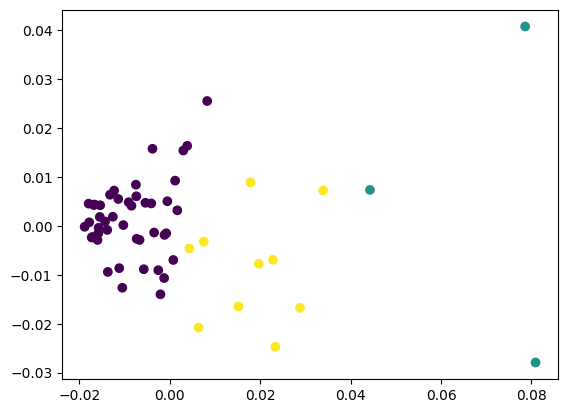

In [ ]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_cv_fALFF_SN.labels_, cmap='viridis')

<Axes: >

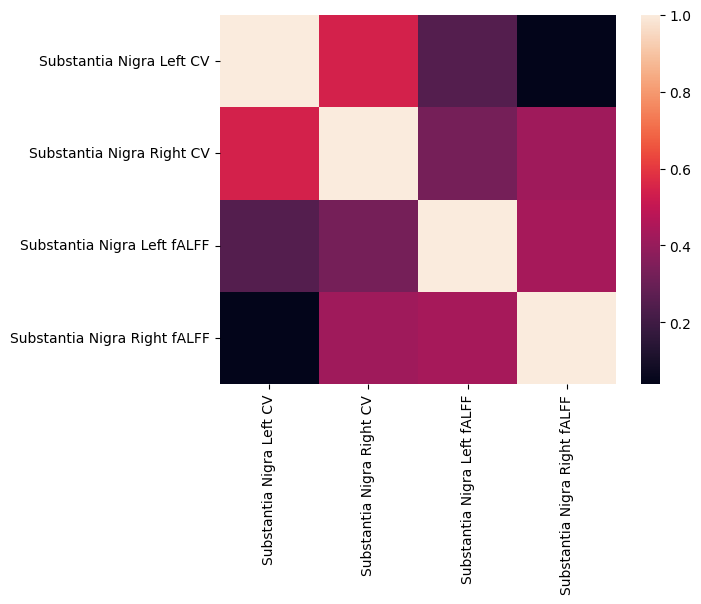

In [37]:
sns.heatmap(cv_fALFF_imputed_df.corr())

0.49239643336241934

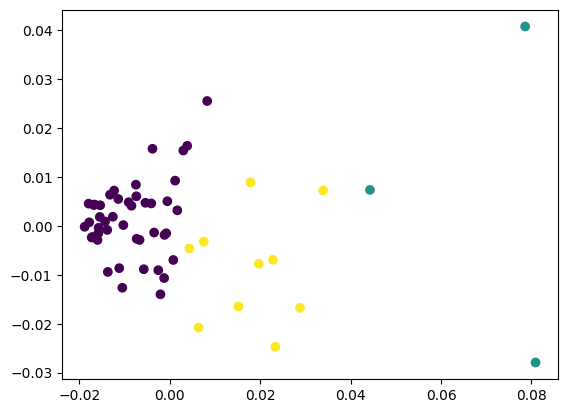

In [74]:
kmeans_cv_fALFF_SN = KMeans(n_clusters=3, random_state=42, n_init=10)
kmeans_cv_fALFF_SN.fit(cv_fALFF_imputed_df)
X_pca = pca.fit_transform(cv_fALFF_imputed_df)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_cv_fALFF_SN.labels_, cmap='viridis')
silhouette_score(cv_fALFF_imputed_df, kmeans_cv_fALFF_SN.labels_)

In [71]:
cv_fALFF_imputed_df.loc[:, ["Substantia Nigra Left fALFF", "Substantia Nigra Right fALFF"]].head()

,Substantia Nigra Left fALFF,Substantia Nigra Right fALFF
0,0.007719,0.007642
1,0.010451,0.008675
2,0.003043,0.006561
3,0.005762,0.007185
4,0.008760,0.007877


0.40012029195367405

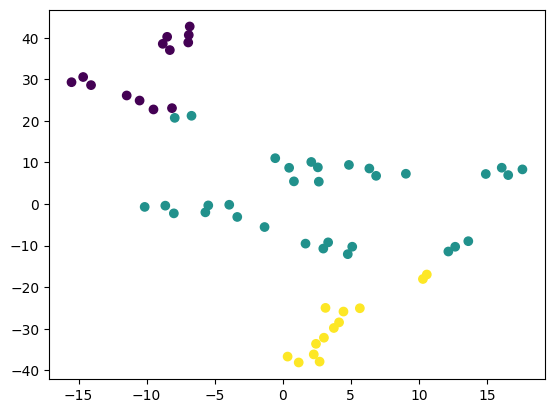

In [80]:
kmeans_cv_fALFF_SN = KMeans(n_clusters=3, random_state=42, n_init=10)
kmeans_cv_fALFF_SN.fit(cv_fALFF_imputed_df.loc[:, ["Substantia Nigra Left fALFF", "Substantia Nigra Right fALFF"]])
X_pca = pca.fit_transform(cv_fALFF_imputed_df.loc[:, ["Substantia Nigra Left fALFF", "Substantia Nigra Right fALFF"]])
tsne = TSNE(perplexity=5)
X_pca_tsne = tsne.fit_transform(cv_fALFF_imputed_df.loc[:, ["Substantia Nigra Left fALFF", "Substantia Nigra Right fALFF"]])
plt.scatter(X_pca_tsne[:, 0], X_pca_tsne[:, 1], c=kmeans_cv_fALFF_SN.labels_, cmap='viridis')
silhouette_score(cv_fALFF_imputed_df.loc[:, ["Substantia Nigra Left fALFF", "Substantia Nigra Right fALFF"]], kmeans_cv_fALFF_SN.labels_)

In [76]:
kmeans.fit(p_imputed_df["global"].values.reshape(-1,1))

KMeans(n_clusters=3, random_state=42)

In [90]:
kmeans.fit(p_imputed_df["global"].values.reshape(-1,1))
kmeans_global_labels = kmeans.labels_

In [91]:
silhouette_score(p_imputed_df["global"].values.reshape(-1,1), kmeans.labels_)

0.5750037250344353

In [84]:
p_imputed_df.columns

Index(['participant_id', 'age', 'sex', 'handedness', 'years_of_education',
       'attention', 'executive', 'global', 'language', 'memory',
       'visuospatial', 'moca_total', 'drs', 'tmt_a', 'tmt_b', 'bta',
       'sdmt_oral', 'bnt', 'cvlt15', 'cvlt_ld_tot', 'fas', 'jlo'],
      dtype='object')

-0.09257961801492885

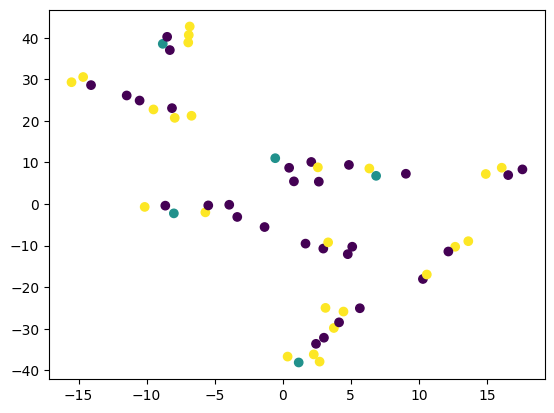

In [82]:
kmeans_cv_fALFF_SN = KMeans(n_clusters=3, random_state=42, n_init=10)
kmeans_cv_fALFF_SN.fit(cv_fALFF_imputed_df.loc[:, ["Substantia Nigra Left fALFF", "Substantia Nigra Right fALFF"]])
X_pca = pca.fit_transform(cv_fALFF_imputed_df.loc[:, ["Substantia Nigra Left fALFF", "Substantia Nigra Right fALFF"]])
tsne = TSNE(perplexity=5)
X_pca_tsne = tsne.fit_transform(cv_fALFF_imputed_df.loc[:, ["Substantia Nigra Left fALFF", "Substantia Nigra Right fALFF"]])
plt.scatter(X_pca_tsne[:, 0], X_pca_tsne[:, 1], c=kmeans_global_labels, cmap='viridis')
silhouette_score(cv_fALFF_imputed_df.loc[:, ["Substantia Nigra Left fALFF", "Substantia Nigra Right fALFF"]], kmeans_global_labels)

In [113]:
feature = "tmt_b"
kmeans.fit(p_imputed_df[feature].values.reshape(-1,1))
kmeans.labels_
silhouette_score(p_imputed_df[feature].values.reshape(-1,1), kmeans.labels_)

0.6339389179108058

### Performing Spectral Clustering

In [37]:
p_imputed_df_columns_to_drop = ['participant_id', 'age', 'sex', 'years_of_education', 'handedness']

In [11]:
cv = cv_df_imputed.loc[:, DMN]

In [16]:
fALFF = fALFF_df_imputed.loc[:, DMN]

In [39]:
p_imputed_features_only = p_imputed_df.drop(p_imputed_df.loc[:, p_imputed_df_columns_to_drop], axis=1)

In [17]:
fALFF_SN = fALFF.loc[:, ["Substantia Nigra Left", "Substantia Nigra Right"]]

In [18]:
labels, connectivity, df_scaled = SpectralClusterDF(fALFF_SN)


silhouette_score: 0.3722


In [19]:
labels

array([0, 2, 1, 1, 0, 2, 0, 0, 1, 1, 2, 2, 2, 0, 0, 0, 0, 1, 0, 2, 0, 1,
       2, 0, 0, 0, 0, 1, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 1, 0, 0, 1, 2,
       1, 0, 1, 1, 0, 1, 1, 2, 2, 0, 2, 0, 1, 0], dtype=int32)

In [20]:
scaler = StandardScaler()

In [21]:
fALFF_SN_scaled = pd.DataFrame(scaler.fit_transform(fALFF_SN), columns=fALFF_SN.columns)

In [22]:
fALFF_SN_scaled["cluster"] = labels

In [23]:
fALFF_SN_scaled.head()

,Substantia Nigra Left,Substantia Nigra Right,cluster
0,0.226016,-0.009171,0
1,2.286151,0.749060,2
2,-3.300138,-0.803165,1
3,-1.249578,-0.344870,1
4,1.010809,0.163341,0


/tmp/ipykernel_22039/1626083436.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis', len(cluster_means))


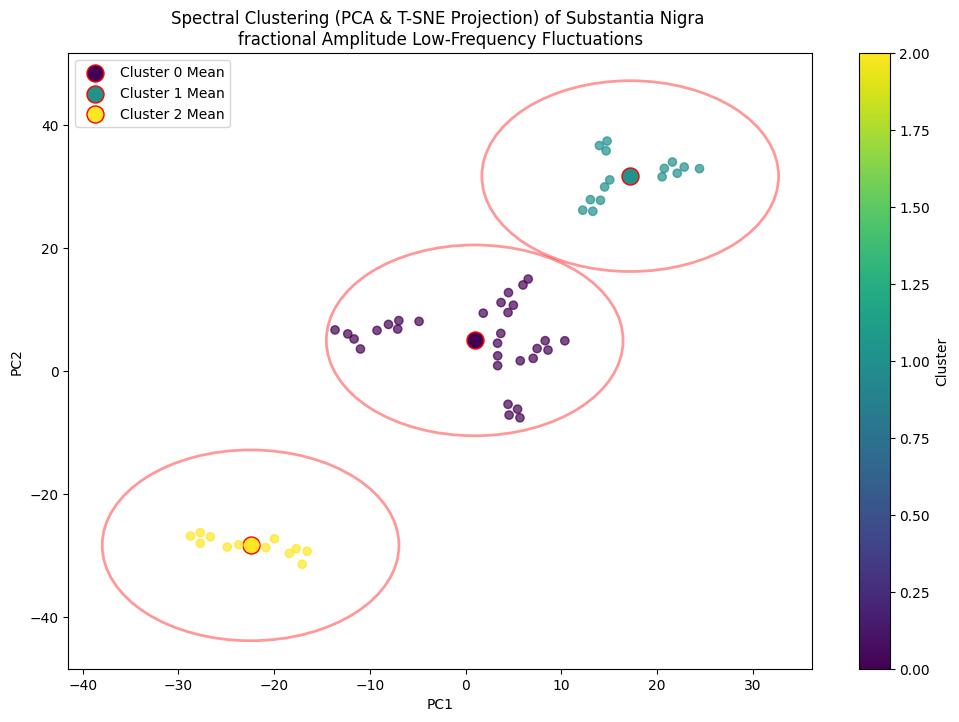

In [24]:
pca = PCA(n_components=2)
tsne = TSNE(perplexity=5)

X_pca = pca.fit_transform(fALFF_SN_scaled)
X_pca_tsne = tsne.fit_transform(X_pca)

X_pca_tsne_df = pd.DataFrame(X_pca_tsne)
X_pca_tsne_df["Cluster"] = labels
cluster_means = X_pca_tsne_df.groupby("Cluster").mean()

# cluster_means.index.values
# cluster_means.loc[:, 0]
# cluster_means

cmap = cm.get_cmap('viridis', len(cluster_means))

plt.figure(figsize=(12, 8))
# Plot cluster means as markers and add red circles
for idx, (x_mean, y_mean) in cluster_means.iterrows():
    cluster_color = cmap(idx)  # Get color from colormap
    plt.scatter(x_mean, y_mean, color=cluster_color, edgecolors='red', s=600, marker='.', label=f'Cluster {idx} Mean')

    # Add a red circle outline around each cluster mean
    circle = plt.Circle((x_mean, y_mean), radius=15.5, color='red', fill=False, linewidth=2, alpha=0.4)
    plt.gca().add_patch(circle)

plt.scatter(X_pca_tsne[:, 0], X_pca_tsne[:, 1], c=labels, cmap='viridis', alpha=0.7)
plt.scatter(x = cluster_means.loc[:, 0], y=cluster_means.loc[:, 1], c=cluster_means.index.values)

plt.title("Spectral Clustering (PCA & T-SNE Projection) of Substantia Nigra \nfractional Amplitude Low-Frequency Fluctuations")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label="Cluster")
plt.legend()
plt.show()


##### Identifying the subjects closest to the mean of the datapoints

In [133]:
cluster_means

,0,1
Cluster,,
0,0.943741,4.949838
1,17.191889,31.641224
2,-22.468418,-28.353584


In [134]:
clustered_tsne = pd.concat([pd.DataFrame(X_pca_tsne), cluster_df], axis=1)

In [82]:
cluster_tsne_0 = clustered_tsne[clustered_tsne["Cluster"] == 0]
cluster_tsne_1 = clustered_tsne[clustered_tsne["Cluster"] == 1]
cluster_tsne_2 = clustered_tsne[clustered_tsne["Cluster"] == 2]

In [90]:
cluster_tsne_0.loc[:, [0, 1]].mean()

0    0.943741
1    4.949838
dtype: float32

In [96]:
cluster_means.iloc[0]

0    0.943741
1    4.949838
Name: 0, dtype: float32

In [104]:
distance_cluster_0_df = pd.DataFrame(np.linalg.norm(cluster_tsne_0.loc[:, [0, 1]].values - cluster_means.iloc[0].values, axis=1))

In [111]:
distance_cluster_0_df.idxmin()

0    0
dtype: int64

In [113]:
cluster_tsne_0.head()

,0,1,Cluster
0,3.330972,4.491594,0
4,-9.260434,6.563298,0
6,-8.062197,7.544353,0
7,-13.645522,6.645609,0
13,-12.315877,5.999021,0


In [114]:
cluster_tsne_1.head()

,0,1,Cluster
2,13.970899,36.605537,1
3,14.519794,29.882259,1
8,20.524858,31.534084,1
9,14.087094,27.716724,1
17,14.673885,35.752811,1


In [116]:
distance_cluster_1_df = pd.DataFrame(np.linalg.norm(cluster_tsne_1.loc[:, [0, 1]].values - cluster_means.iloc[1].values, axis=1))

In [115]:
cluster_tsne_2.head()

,0,1,Cluster
1,-17.074583,-31.439070,2
5,-17.695215,-28.891895,2
10,-23.693512,-28.252983,2
11,-22.026503,-28.296486,2
12,-19.976606,-27.277632,2


In [117]:
distance_cluster_2_df = pd.DataFrame(np.linalg.norm(cluster_tsne_2.loc[:, [0, 1]].values - cluster_means.iloc[2].values, axis=1))

In [118]:
distance_cluster_0_df

,0
0,2.430815
1,10.330946
2,9.372215
3,14.687486
4,13.301062
5,6.578599
6,12.016520
7,4.515311
8,4.750658
9,2.955302


In [129]:
distance_cluster_0_df.idxmin()

0    0
dtype: int64

In [126]:
distance_cluster_1_df.idxmin()

0    10
dtype: int64

In [127]:
distance_cluster_2_df.idxmin()

0    3
dtype: int64

In [ ]:
# This is why the above worked and using KMeans, PCA, & T-SNE did not:

# Compute Convex Hull
# df_scaled is returned from 
# fALFF_SN = fALFF.loc[:, ["Substantia Nigra Left", "Substantia Nigra Right"]]
# labels, connectivity, df_scaled = SpectralClusterDF(fALFF_SN)

hull = ConvexHull(fALFF_SN_scaled)

# Compute convex hull volume (or area in 2D)
hull_volume = hull.volume if fALFF_SN_scaled.shape[1] > 2 else hull.area

# Compute bounding box volume (approximation of occupied space)
data_volume = np.prod(np.ptp(fALFF_SN_scaled, axis=0))  # Range product as bounding box volume

# Convexity Ratio
convexity_ratio = hull_volume / data_volume
print(f"Convexity Ratio: {convexity_ratio:.4f}")

Convexity Ratio: 0.3037


##### Why Spectral Clustering to Identify the Labels and Cluster the Data Worked:
The Convexity Ratio is less than 1
Values close to 1 are convex
Values much less than 1 are non-convex
PCA works with convex data, the resulting clusters should appear spherical
Spectral Clustering & DBSCAN works with non-convex clusters and those should appear non-spherical under PCA

Convex Hull Ratio:

A Convex Hull Ratio compares the volume (or area in 2D) of the convex hull enclosing the data to the actual volume occupied by the data points.
Convexity Ratio=Convex Hull Volume (or Area) / Data Point Volume (or Area)
Convex Hull Ratio close to 1: data is convex
Convex Hull Ratio close to 0: a large empty space between the hull and the data indicating non-convex data

In [ ]:
# fALFF_SN_scaled["Cluster"].to_csv("../data/dataframes/groups.csv", index=False)

In [181]:
p_imputed_df["Cluster"] = labels

In [ ]:
# p_imputed_df.to_csv("../data/dataframes/p_imputed_with_fALFF_spectral_clustering.csv", index=False)

In [275]:
p_imputed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58 entries, 0 to 57
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   participant_id      58 non-null     object 
 1   age                 58 non-null     object 
 2   sex                 58 non-null     int64  
 3   handedness          58 non-null     int64  
 4   years_of_education  58 non-null     int64  
 5   attention           58 non-null     float64
 6   executive           58 non-null     float64
 7   global              58 non-null     float64
 8   language            58 non-null     float64
 9   memory              58 non-null     float64
 10  visuospatial        58 non-null     float64
 11  moca_total          58 non-null     float64
 12  drs                 58 non-null     float64
 13  tmt_a               58 non-null     float64
 14  tmt_b               58 non-null     float64
 15  bta                 58 non-null     float64
 16  sdmt_oral 

In [277]:
df = p_imputed_df

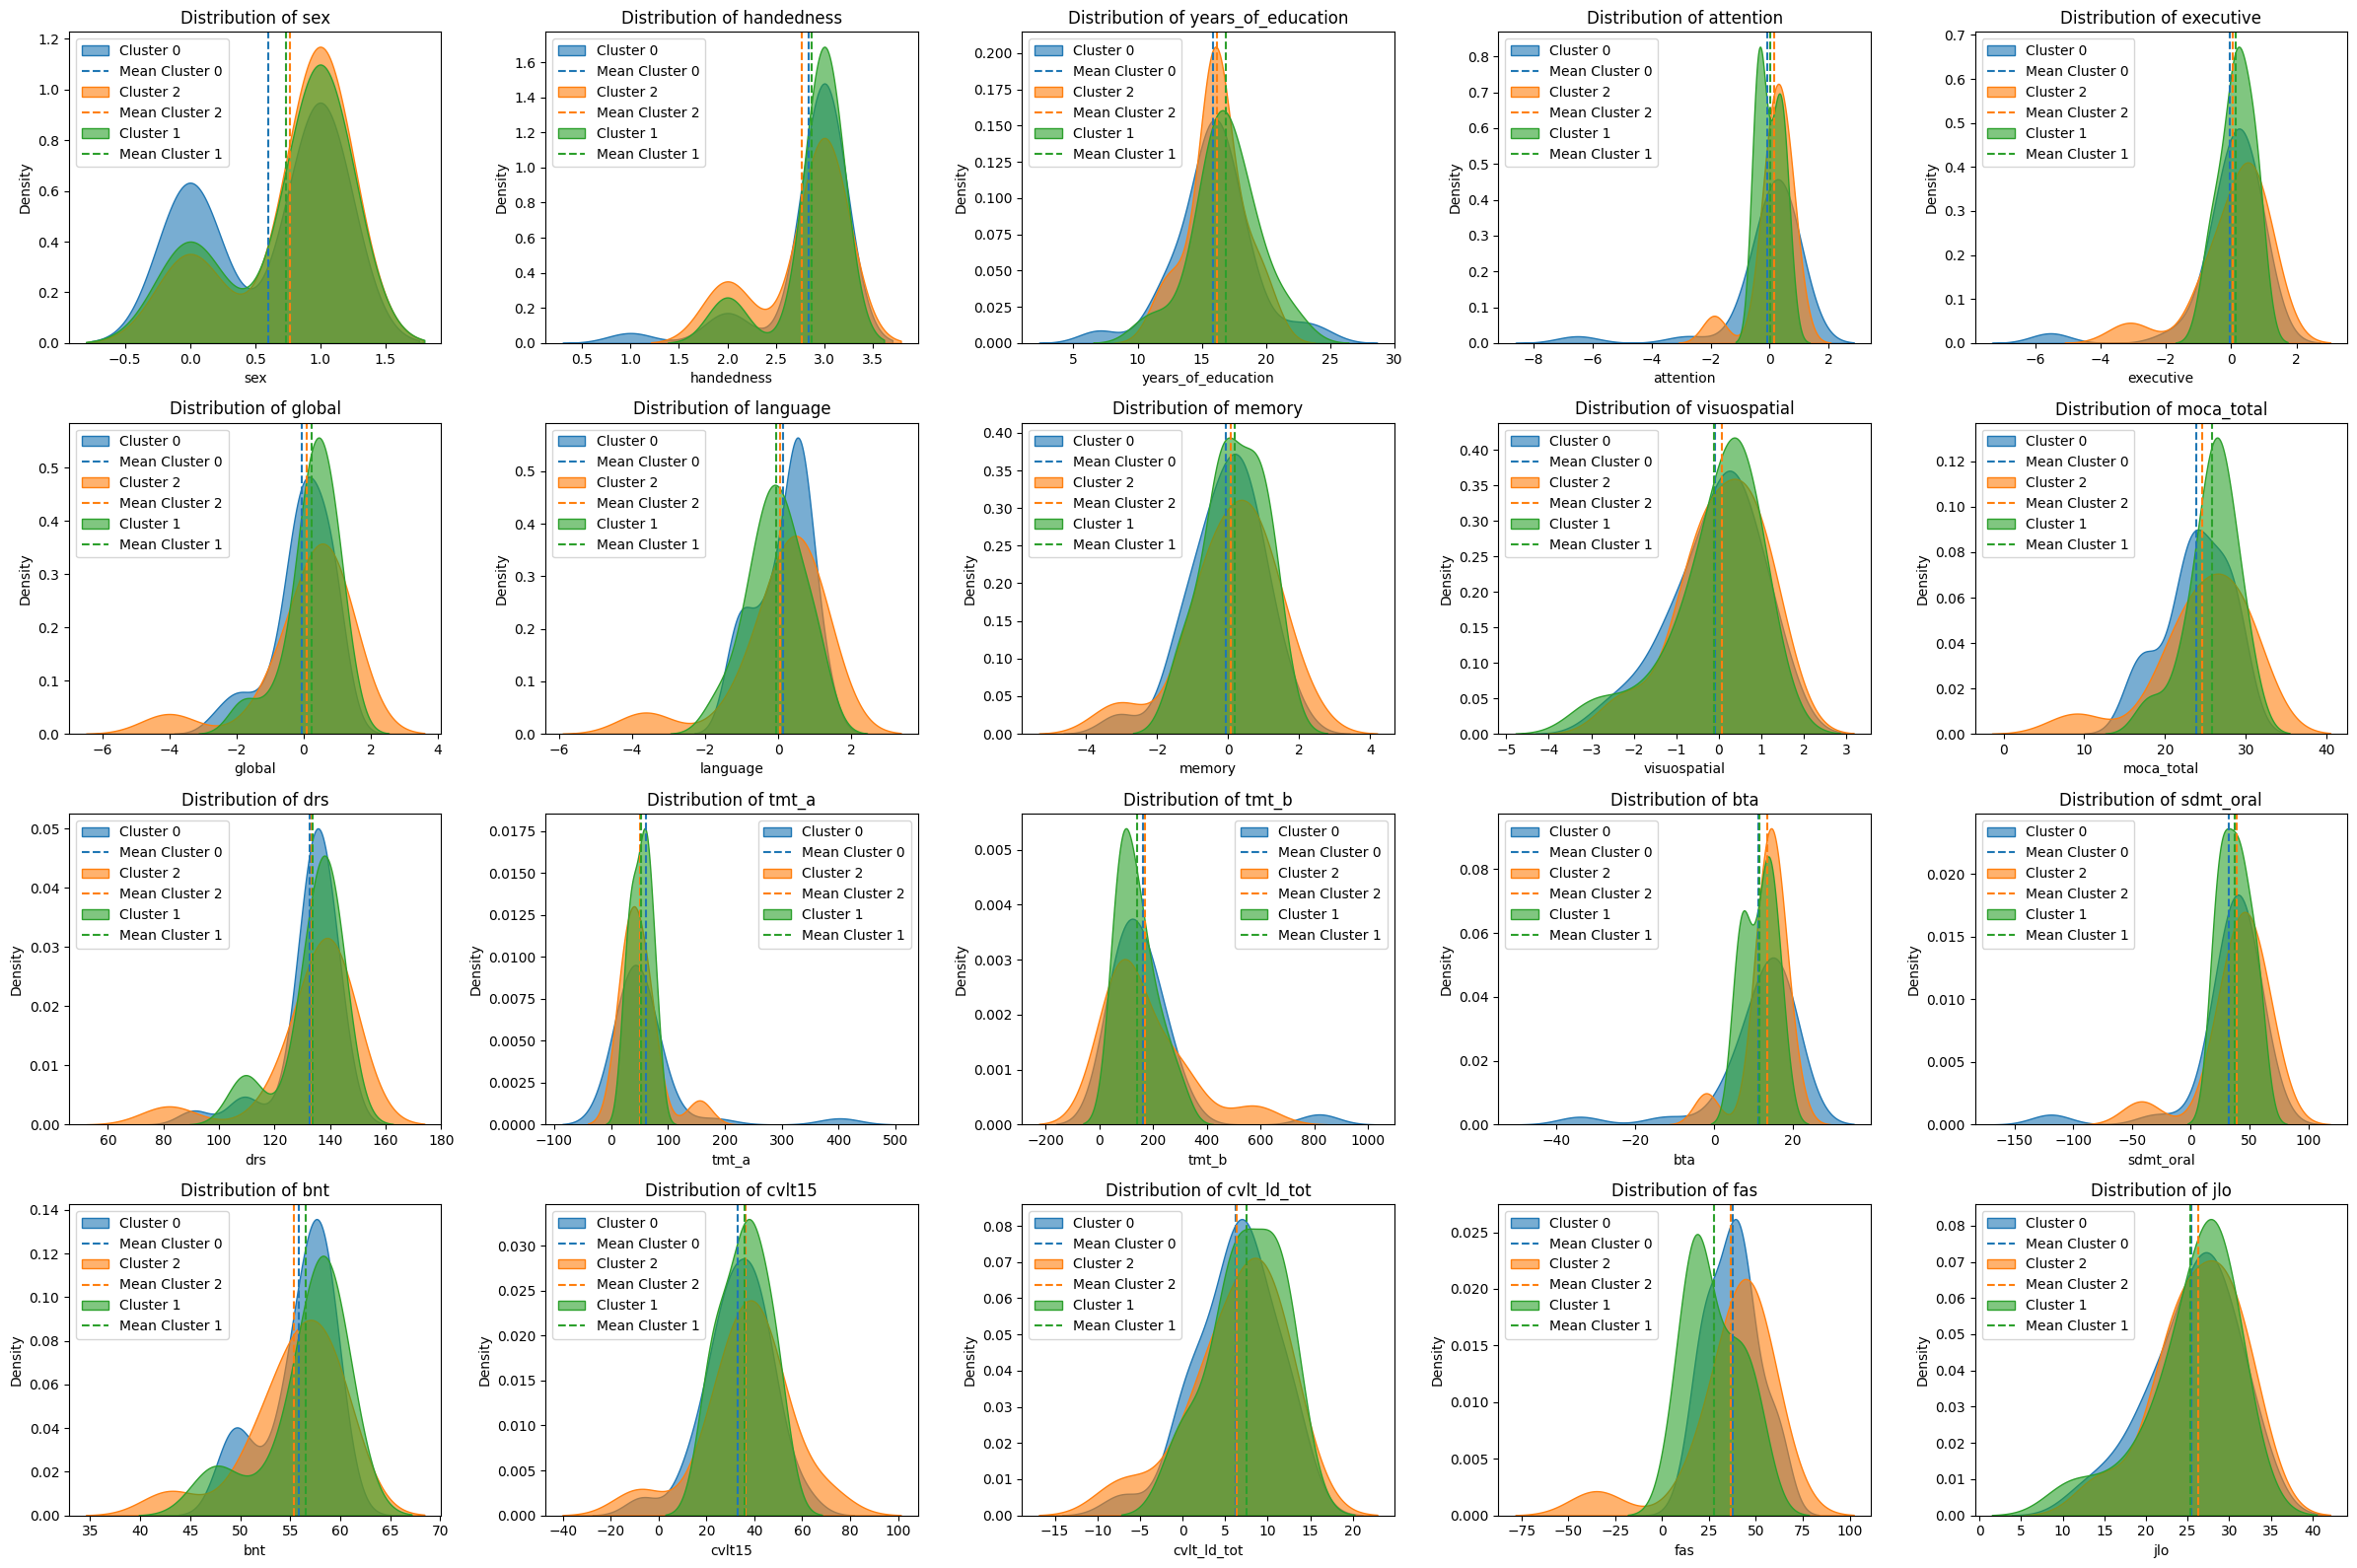

In [ ]:
# Assuming your DataFrame is named `df`
# Extract the numeric columns (excluding 'Cluster', 'participant_id', and 'age')
numeric_columns = df.drop(columns=['Cluster', 'participant_id', 'age']).select_dtypes(include=['float64', 'int64']).columns

# Set up the plotting grid
plt.figure(figsize=(24, 16))

# Define a color palette to use consistently across the clusters
palette = sns.color_palette("tab10", len(df['Cluster'].unique()))  # A fixed color palette

# Loop through each numeric feature
for i, feature in enumerate(numeric_columns):
    plt.subplot(4, 5, i + 1)  # Adjust 4, 5 based on the number of features you have
    for j, cluster in enumerate(df['Cluster'].unique()):
        # Select the data for the current cluster
        cluster_data = df[df['Cluster'] == cluster][feature]
        
        # Plot the distribution using a KDE plot (you can also use a histogram with sns.histplot)
        sns.kdeplot(cluster_data, label=f'Cluster {cluster}', fill=True, alpha=0.6, color=palette[j])
        
        # Calculate the mean of the current feature for the current cluster
        cluster_mean = cluster_data.mean()
        
        # Plot a vertical line at the mean of the current feature for the current cluster
        plt.axvline(cluster_mean, color=palette[j], linestyle='--', label=f'Mean Cluster {cluster}')

    # Add labels and title for each subplot
    plt.title(f'Distribution of {feature}')
    plt.xlabel(f'{feature}')
    plt.ylabel('Density')
    plt.legend()

# Adjust layout for clarity
plt.tight_layout()
plt.show()


<Axes: >

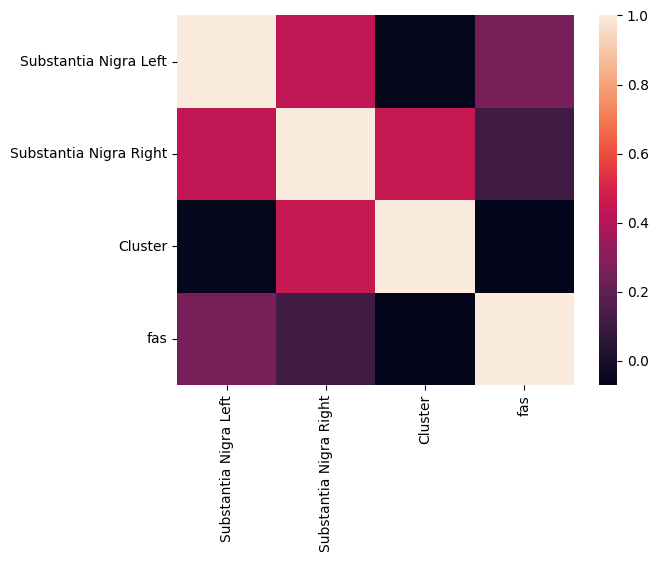

In [286]:
sns.heatmap(pd.concat([fALFF_SN_scaled, p_imputed_df.loc[:, "fas"]], axis=1).corr())

In [290]:
# Presuming the Progression of Healthy to MCI to PDD and Evaluating Based on the means.
# Cluster 1, according to the fALFF, is PDD, 
# Cluster 0 is MCI
# Cluster 2 is Healthy Cognition
fALFF_SN_scaled.groupby("Cluster").mean().to_csv("../data/dataframes/fALFF_SN_scaled_means_cluster_key_index.csv")

In [10]:
cluster_key_df = pd.read_csv("../data/dataframes/fALFF_SN_scaled_means_cluster_key_index.csv", index_col=0)

In [ ]:
# p_imputed_df.loc[:, ["participant_id", "Cluster"]].to_csv("../data/dataframes/participant_cluster_pairs.csv", index=False)

In [301]:
p_imputed_df.loc[:, ["participant_id", "Cluster"]].values

array([['sub-0202', 0],
       ['sub-0203', 2],
       ['sub-0204', 1],
       ['sub-0205', 1],
       ['sub-0206', 0],
       ['sub-0207', 2],
       ['sub-0209', 0],
       ['sub-0210', 0],
       ['sub-0212', 1],
       ['sub-0213', 1],
       ['sub-0214', 2],
       ['sub-0222', 2],
       ['sub-0224', 2],
       ['sub-0226', 0],
       ['sub-0227', 0],
       ['sub-0230', 0],
       ['sub-0231', 0],
       ['sub-0232', 1],
       ['sub-0233', 0],
       ['sub-0234', 2],
       ['sub-0235', 0],
       ['sub-0237', 1],
       ['sub-0238', 2],
       ['sub-0240', 0],
       ['sub-0242', 0],
       ['sub-0243', 0],
       ['sub-0246', 0],
       ['sub-0247', 1],
       ['sub-0249', 0],
       ['sub-0250', 2],
       ['sub-0252', 0],
       ['sub-0253', 0],
       ['sub-0255', 0],
       ['sub-0256', 2],
       ['sub-0257', 0],
       ['sub-0258', 0],
       ['sub-0263', 0],
       ['sub-0264', 0],
       ['sub-0265', 0],
       ['sub-0267', 1],
       ['sub-0270', 0],
       ['sub-027

## Next Steps

- [ ] Create a connectivity Graph 

# Data Wrangling the clustered dataframes

In [10]:
fALFF_df_imputed.head()

,Frontal Pole,Insular Cortex,Superior Frontal Gyrus,Middle Frontal Gyrus,"Inferior Frontal Gyrus, pars triangularis","Inferior Frontal Gyrus, pars opercularis",Precentral Gyrus,Temporal Pole,"Superior Temporal Gyrus, anterior division","Superior Temporal Gyrus, posterior division",...,Right Lateral Ventricle,Right Thalamus,Right Caudate,Right Putamen,Right Pallidum,Right Hippocampus,Right Amygdala,Right Accumbens,Substantia Nigra Right,Substantia Nigra Left
0,0.011413,0.010983,0.010253,0.010471,0.011631,0.010933,0.011267,0.008058,0.008130,0.010452,...,0.009588,0.011064,0.009658,0.010349,0.009297,0.008296,0.008801,0.010626,0.007642,0.007719
1,0.008063,0.008100,0.008432,0.008537,0.008519,0.008345,0.008678,0.007926,0.008483,0.008496,...,0.007906,0.007987,0.007816,0.008021,0.008095,0.008172,0.009426,0.009352,0.008675,0.010451
2,0.010883,0.010724,0.013460,0.011124,0.011169,0.011045,0.013046,0.007863,0.010838,0.008925,...,0.007646,0.009958,0.009135,0.009343,0.009173,0.008074,0.007594,0.006212,0.006561,0.003043
3,0.012848,0.011475,0.012581,0.012059,0.011521,0.010469,0.012200,0.009404,0.009567,0.009665,...,0.007286,0.006726,0.008681,0.008327,0.008582,0.008873,0.006382,0.008044,0.007185,0.005762
4,0.010721,0.008784,0.009308,0.009108,0.010489,0.010703,0.008949,0.007983,0.009652,0.009742,...,0.008811,0.008961,0.006450,0.008073,0.008078,0.009224,0.008114,0.007508,0.007877,0.008760


In [13]:
cv_df_imputed.head()

,Frontal Pole,Insular Cortex,Superior Frontal Gyrus,Middle Frontal Gyrus,"Inferior Frontal Gyrus, pars triangularis","Inferior Frontal Gyrus, pars opercularis",Precentral Gyrus,Temporal Pole,"Superior Temporal Gyrus, anterior division","Superior Temporal Gyrus, posterior division",...,Right Lateral Ventricle,Right Thalamus,Right Caudate,Right Putamen,Right Pallidum,Right Hippocampus,Right Amygdala,Right Accumbens,Substantia Nigra Right,Substantia Nigra Left
0,0.007361,0.004123,0.003377,0.003526,0.004109,0.004509,0.003287,0.006441,0.004820,0.004280,...,0.003367,0.005808,0.012133,0.007270,0.016889,0.013879,0.026816,0.071313,0.013934,0.024464
1,0.015797,0.018319,0.022378,0.019799,0.019887,0.016706,0.019045,0.018231,0.020285,0.016501,...,0.049101,0.054028,0.060103,0.018755,0.014706,0.025465,0.028863,0.070590,0.052207,0.108072
2,0.004760,0.004682,0.006065,0.004987,0.006065,0.006556,0.006051,0.003977,0.005636,0.005841,...,0.005002,0.006167,0.011677,0.002962,0.006408,0.005817,0.019217,0.017145,0.011508,0.032281
3,0.006936,0.007587,0.006876,0.006616,0.007496,0.006326,0.005463,0.010617,0.007100,0.008672,...,0.006510,0.006285,0.007420,0.004251,0.005474,0.006373,0.011001,0.018198,0.010301,0.014950
4,0.004008,0.003126,0.003351,0.003580,0.004475,0.003954,0.003441,0.007030,0.003373,0.003251,...,0.003354,0.004243,0.005806,0.002414,0.004007,0.004253,0.009129,0.006102,0.009201,0.014344


In [14]:
p_imputed_df.head()

,participant_id,age,sex,handedness,years_of_education,attention,executive,global,language,memory,...,drs,tmt_a,tmt_b,bta,sdmt_oral,bnt,cvlt15,cvlt_ld_tot,fas,jlo
0,sub-0202,76.9260273972603,1,3,16,0.74333,0.08219,-0.12135,0.58319,-1.26360,...,133.0,27.82,159.49,19.0,38.0,59.0,17.0,1.0,39.0,25.0
1,sub-0203,73.3257654016019,1,2,12,0.22898,-0.72817,0.25027,-0.24200,-0.66063,...,136.0,59.25,301.23,16.0,25.0,52.0,27.0,3.0,42.0,24.0
2,sub-0204,55.0602739726027,1,3,14,0.18272,0.18931,0.41475,-0.36043,0.95818,...,137.0,51.38,161.55,14.0,44.0,56.0,43.0,12.0,20.0,22.0
3,sub-0205,77.43231529306091,1,3,16,0.35645,0.12266,0.29293,-0.25917,0.61895,...,137.0,34.50,144.40,14.0,37.0,57.0,37.0,11.0,19.0,11.0
4,sub-0206,72.0191780821918,1,3,12,0.30705,0.00481,-0.15784,-1.18563,0.46936,...,135.0,39.30,169.34,14.0,36.0,49.0,42.0,8.0,23.0,29.0


In [15]:
cluster_df = pd.read_csv("../data/dataframes/groups.csv")

In [ ]:
# Create clustered dataframes
# p_imputed_df_clustered = pd.concat([p_imputed_df, cluster_df], axis=1)
# fALFF_df_imputed_clustered = pd.concat([fALFF_df_imputed, cluster_df], axis=1)
# cv_df_imputed_clustered = pd.concat([cv_df_imputed, cluster_df], axis=1)

In [ ]:
# p_imputed_df_clustered.rename(columns={"Cluster":"cluster"}, inplace=True)
# fALFF_df_imputed_clustered.rename(columns={"Cluster":"cluster"}, inplace=True)
# cv_df_imputed_clustered.rename(columns={"Cluster":"cluster"}, inplace=True)

In [ ]:
# Saving Clusters
# df_dir = "../data/dataframes/cluster/"
# p_imputed_df_clustered.to_csv(df_dir + "p_imputed_df_clustered.csv", index=False)
# fALFF_df_imputed_clustered.to_csv(df_dir + "fALFF_df_imputed_clustered.csv", index=False)
# cv_df_imputed_clustered.to_csv(df_dir + "cv_df_imputed_clustered.csv", index=False)

# Reading the clustered dataframes

In [ ]:
# Cluster 0: MCI
# Cluster 1: PDD
# Cluster 2: Cognitively Normal
# cluster_key_df["Cognitive Health"] = ["MCI", "PDD", "Cognitively Normal"]
# cluster_key_df.to_csv("../data/dataframes/cluster_key_df_labeled.csv")

In [103]:
df_dir = "../data/dataframes/cluster/"
cluster_key_df = pd.read_csv("../data/dataframes/cluster_key_df_labeled.csv", index_col=0)
p_imputed_df_clustered = pd.read_csv(df_dir + "p_imputed_df_clustered.csv")
fALFF_df_imputed_clustered = pd.read_csv(df_dir + "fALFF_df_imputed_clustered.csv")
cv_df_imputed_clustered = pd.read_csv(df_dir + "cv_df_imputed_clustered.csv")

In [104]:
cluster_key_df

,Substantia Nigra Left,Substantia Nigra Right,Cognitive Health
Cluster,,,
0,0.332347,-0.091915,MCI
1,-1.161762,-1.059544,PDD
2,0.573540,1.434661,Cognitively Normal


In [105]:
# People with fALFF pca tsne scores that are closest to the mean for each cluster group
p_imputed_df_clustered.iloc[[0, 3, 10], :]

,participant_id,age,sex,handedness,years_of_education,attention,executive,global,language,memory,...,tmt_a,tmt_b,bta,sdmt_oral,bnt,cvlt15,cvlt_ld_tot,fas,jlo,cluster
0,sub-0202,76.9260273972603,1,3,16,0.74333,0.08219,-0.12135,0.58319,-1.26360,...,27.82,159.49,19.0,38.0,59.0,17.0,1.0,39.0,25.0,0
3,sub-0205,77.43231529306091,1,3,16,0.35645,0.12266,0.29293,-0.25917,0.61895,...,34.50,144.40,14.0,37.0,57.0,37.0,11.0,19.0,11.0,1
10,sub-0214,68.0575342465753,1,2,16,-0.09870,0.36773,0.29912,1.07760,0.16787,...,66.36,116.44,12.0,44.0,59.0,37.0,7.0,56.0,29.0,2


In [ ]:
# Create a functional connectivity matrix of the 3 individuals given the fALFF scores where each region is a node and the fALFF difference between the regions are the edge weights. Map this to an anatomically correct brain to visualize the results of the graph. 

In [32]:
fALFF_df_imputed_clustered.head()

,Frontal Pole,Insular Cortex,Superior Frontal Gyrus,Middle Frontal Gyrus,"Inferior Frontal Gyrus, pars triangularis","Inferior Frontal Gyrus, pars opercularis",Precentral Gyrus,Temporal Pole,"Superior Temporal Gyrus, anterior division","Superior Temporal Gyrus, posterior division",...,Right Thalamus,Right Caudate,Right Putamen,Right Pallidum,Right Hippocampus,Right Amygdala,Right Accumbens,Substantia Nigra Right,Substantia Nigra Left,cluster
0,0.011413,0.010983,0.010253,0.010471,0.011631,0.010933,0.011267,0.008058,0.008130,0.010452,...,0.011064,0.009658,0.010349,0.009297,0.008296,0.008801,0.010626,0.007642,0.007719,0
1,0.008063,0.008100,0.008432,0.008537,0.008519,0.008345,0.008678,0.007926,0.008483,0.008496,...,0.007987,0.007816,0.008021,0.008095,0.008172,0.009426,0.009352,0.008675,0.010451,2
2,0.010883,0.010724,0.013460,0.011124,0.011169,0.011045,0.013046,0.007863,0.010838,0.008925,...,0.009958,0.009135,0.009343,0.009173,0.008074,0.007594,0.006212,0.006561,0.003043,1
3,0.012848,0.011475,0.012581,0.012059,0.011521,0.010469,0.012200,0.009404,0.009567,0.009665,...,0.006726,0.008681,0.008327,0.008582,0.008873,0.006382,0.008044,0.007185,0.005762,1
4,0.010721,0.008784,0.009308,0.009108,0.010489,0.010703,0.008949,0.007983,0.009652,0.009742,...,0.008961,0.006450,0.008073,0.008078,0.009224,0.008114,0.007508,0.007877,0.008760,0


In [14]:
typical_persons_for_each_cluster = [0,3,10]

In [15]:
SN_regions = ["Substantia Nigra Left", "Substantia Nigra Right"]

In [16]:
fALFF_df_imputed_clustered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58 entries, 0 to 57
Data columns (total 72 columns):
 #   Column                                                               Non-Null Count  Dtype  
---  ------                                                               --------------  -----  
 0   Frontal Pole                                                         58 non-null     float64
 1   Insular Cortex                                                       58 non-null     float64
 2   Superior Frontal Gyrus                                               58 non-null     float64
 3   Middle Frontal Gyrus                                                 58 non-null     float64
 4   Inferior Frontal Gyrus, pars triangularis                            58 non-null     float64
 5   Inferior Frontal Gyrus, pars opercularis                             58 non-null     float64
 6   Precentral Gyrus                                                     58 non-null     float64
 7   Temporal P

In [17]:
falff_data = fALFF_df_imputed_clustered.iloc[typical_persons_for_each_cluster, :].loc[:, SN_regions]

In [18]:
test = falff_data.iloc[:2, :]

In [19]:
falff_data["Substantia Nigra Right"][::-1].diff()

10         NaN
3    -0.002273
0     0.000457
Name: Substantia Nigra Right, dtype: float64

In [ ]:
cognitively_normal_df = fALFF_df_imputed_clustered[fALFF_df_imputed_clustered["cluster"] == 2].copy()

In [36]:
MCI_df = fALFF_df_imputed_clustered[fALFF_df_imputed_clustered["cluster"] == 0].copy()

In [37]:
PDD_df = fALFF_df_imputed_clustered[fALFF_df_imputed_clustered["cluster"] == 1].copy() 

In [ ]:
# cognitively_normal_df.drop(columns="cluster", inplace=True)
# MCI_df.drop(columns="cluster", inplace=True)
# PDD_df.drop(columns="cluster", inplace=True)

## Identifying Statistically Significant Correlated Regions to the Right Substantia Nigra in Each Group

Critical value (for 95% confidence): 1.9600


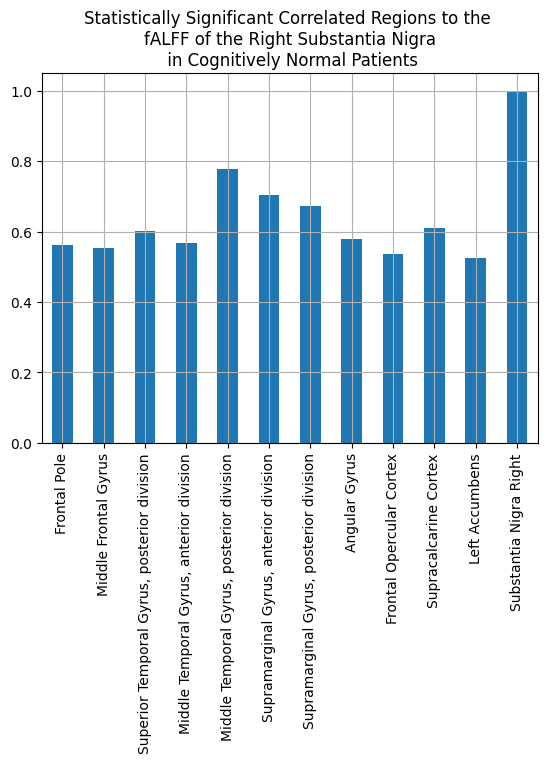

In [231]:
cognitively_normal_df.shape
std = np.std(cognitively_normal_df.corr()["Substantia Nigra Right"].values)
diff = cognitively_normal_df.corr()["Substantia Nigra Right"] - 1
z_score_l = diff / std

# Significance level (usually 0.05 for 95% confidence)
alpha = 0.05

# Calculate the critical value for a two-tailed test (for 95% confidence)
critical_value = norm.ppf(1 - alpha / 2)
critical_value

# Print the critical value
print(f"Critical value (for 95% confidence): {critical_value:.4f}")
stat_sig_l_cogn = []
# Check if the Z-score is greater than the critical value
for z_score in z_score_l:
    if abs(z_score) > critical_value:
        # print("The difference is statistically significant.")
        stat_sig_l_cogn.append(1)
    else:
        # print("The difference is not statistically significant.")
        stat_sig_l_cogn.append(0)
region_list = cognitively_normal_df.columns.values
stat_sig_l_cogn_df = pd.DataFrame(stat_sig_l_cogn, region_list, columns=["Cognitively Normal SN Corr"])
statistically_significant_regions_cog_normal = stat_sig_l_cogn_df[stat_sig_l_cogn_df["Cognitively Normal SN Corr"] == 0].index.values
cognitively_normal_df.corr()["Substantia Nigra Right"][statistically_significant_regions_cog_normal].plot(kind='bar')
plt.title("Statistically Significant Correlated Regions to the \nfALFF of the Right Substantia Nigra\n in Cognitively Normal Patients")
plt.grid(True)

### Creating a Graph of the weighted correlations to the Substantia Nigra

In [ ]:
edge_correlations = cognitively_normal_df.corr()["Substantia Nigra Right"][statistically_significant_regions_cog_normal][:-1].values

In [218]:
edge_correlations

array([0.56237782, 0.55245634, 0.60283723, 0.56713913, 0.77890144,
       0.70299698, 0.67212069, 0.5793889 , 0.53525374, 0.61003748,
       0.5256832 ])

In [ ]:
nodes = cognitively_normal_df.corr()["Substantia Nigra Right"][statistically_significant_regions_cog_normal].index.values

In [219]:
nodes

array(['Frontal Pole', 'Middle Frontal Gyrus',
       'Superior Temporal Gyrus, posterior division',
       'Middle Temporal Gyrus, anterior division',
       'Middle Temporal Gyrus, posterior division',
       'Supramarginal Gyrus, anterior division',
       'Supramarginal Gyrus, posterior division', 'Angular Gyrus',
       'Frontal Opercular Cortex', 'Supracalcarine Cortex',
       'Left Accumbens', 'Substantia Nigra Right'], dtype=object)

In [220]:
edge_correlations

array([0.56237782, 0.55245634, 0.60283723, 0.56713913, 0.77890144,
       0.70299698, 0.67212069, 0.5793889 , 0.53525374, 0.61003748,
       0.5256832 ])

In [ ]:
cognitively_normal_stat_sign_corr_graph = nx.Graph()

In [ ]:
cognitively_normal_stat_sign_corr_graph.add_nodes_from(nodes)

In [ ]:
for index, node in enumerate(nodes[:-1]):
    cognitively_normal_stat_sign_corr_graph.add_edge(node, "Substantia Nigra Right", weight=edge_correlations[index])
    

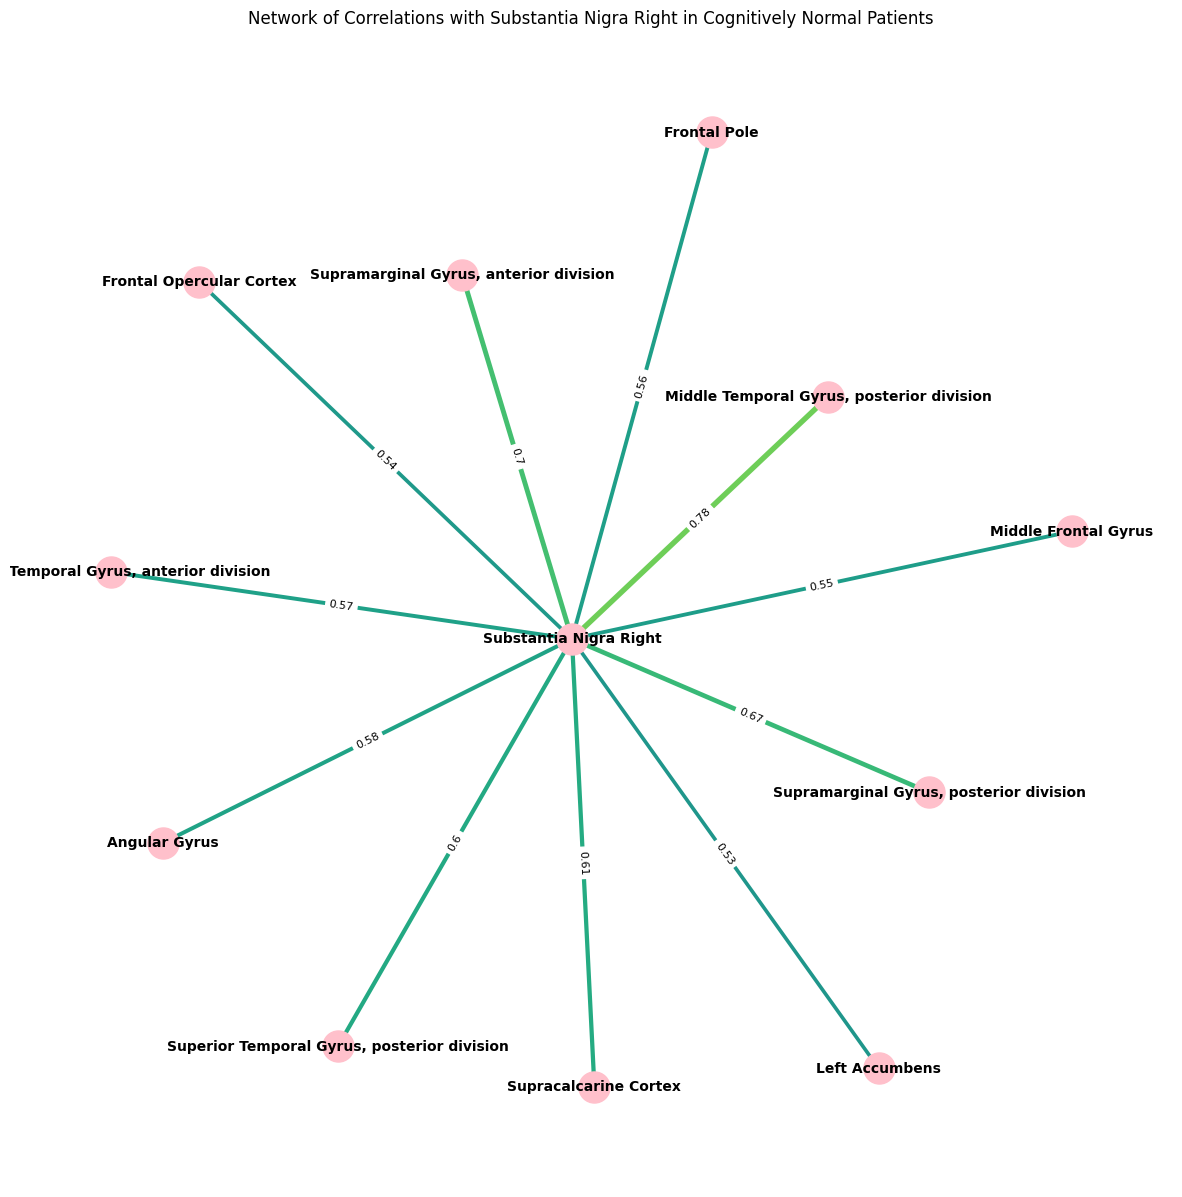

In [ ]:
# Prepare the edge weights, thickness, and colors
edge_weights = [data['weight'] for _, _, data in cognitively_normal_stat_sign_corr_graph.edges(data=True)]
edge_thickness = [weight * 5 for weight in edge_weights]  # Scaling for better visibility
edge_colors = [cm.viridis(weight) for weight in edge_weights]  # Using a colormap for colors

# Draw the graph
pos = nx.spring_layout(cognitively_normal_stat_sign_corr_graph, seed=42)  # Positioning of nodes
plt.figure(figsize=(15, 15))

# Draw nodes
nx.draw_networkx_nodes(cognitively_normal_stat_sign_corr_graph, pos, node_size=500, node_color='pink')

# Draw edges with weights (correlations)
edges = cognitively_normal_stat_sign_corr_graph.edges(data=True)
nx.draw_networkx_edges(cognitively_normal_stat_sign_corr_graph, pos, edgelist=edges, width=edge_thickness, edge_color=edge_colors)

# Draw labels
nx.draw_networkx_labels(cognitively_normal_stat_sign_corr_graph, pos, font_size=10, font_weight='bold')

# Add edge labels for correlations
edge_labels = {(node, 'Substantia Nigra Right'): f'{round(weight["weight"], 2)}' for node, _, weight in edges}
nx.draw_networkx_edge_labels(cognitively_normal_stat_sign_corr_graph, pos, edge_labels=edge_labels, font_size=8)

# Show plot
plt.title("Network of Correlations with Substantia Nigra Right in Cognitively Normal Patients")
plt.axis('off')
plt.show()

## Statistically Significant Correlations with the Substantia Nigra Right in Parkinson's MCI patients 

Critical value (for 95% confidence): 1.9600


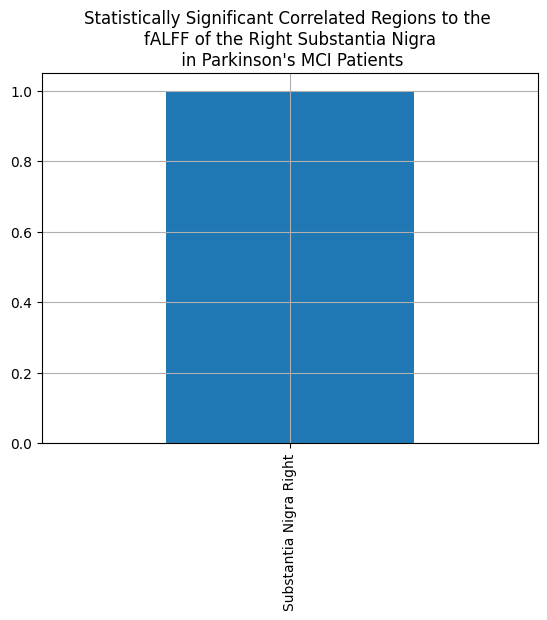

In [238]:
MCI_df.shape
std = np.std(MCI_df.corr()["Substantia Nigra Right"].values)
diff = MCI_df.corr()["Substantia Nigra Right"] - 1
z_score_l = diff / std

# Significance level (usually 0.05 for 95% confidence)
alpha = 0.05

# Calculate the critical value for a two-tailed test (for 95% confidence)
critical_value = norm.ppf(1 - alpha / 2)
critical_value

# Print the critical value
print(f"Critical value (for 95% confidence): {critical_value:.4f}")
stat_sig_l_mci = []
# Check if the Z-score is greater than the critical value
for z_score in z_score_l:
    if abs(z_score) > critical_value:
        # print("The difference is statistically significant.")
        stat_sig_l_mci.append(1)
    else:
        # print("The difference is not statistically significant.")
        stat_sig_l_mci.append(0)
region_list = MCI_df.columns.values
stat_sig_l_mci_df = pd.DataFrame(stat_sig_l_mci, region_list, columns=["MCI SN Corr"])
statistically_significant_regions_mci = stat_sig_l_mci_df[stat_sig_l_mci_df["MCI SN Corr"] == 0].index.values
MCI_df.corr()["Substantia Nigra Right"][statistically_significant_regions_mci].plot(kind='bar')
plt.title("Statistically Significant Correlated Regions to the \nfALFF of the Right Substantia Nigra\n in Parkinson's MCI Patients")
plt.grid(True)

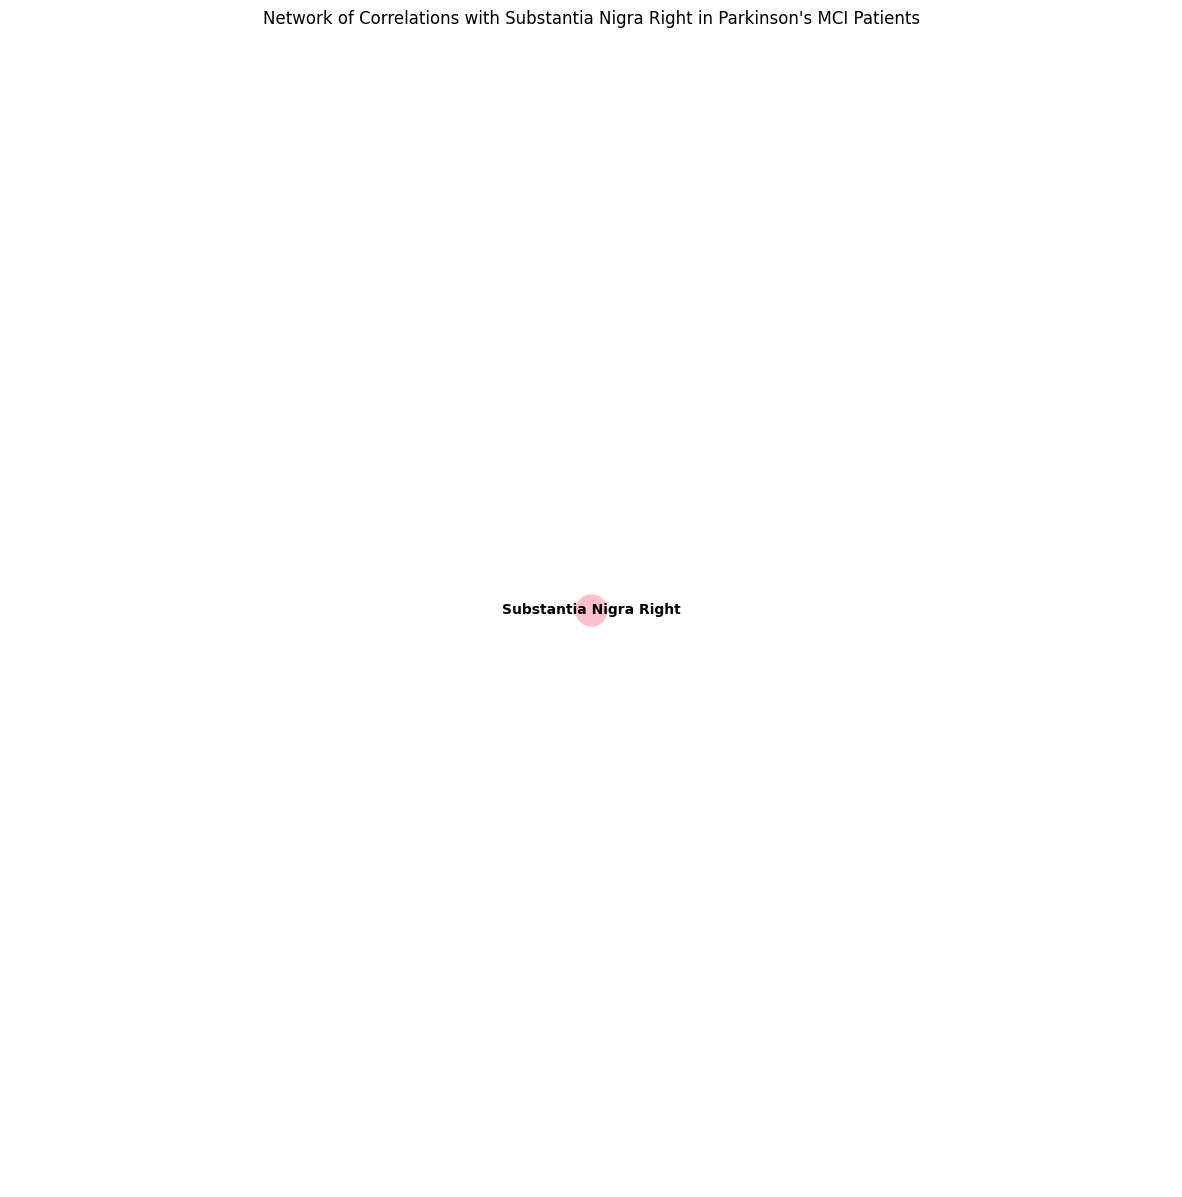

In [ ]:
# mci_edge_correlations = MCI_df.corr()["Substantia Nigra Right"][statistically_significant_regions_mci][:-1].values
# mci_nodes = cognitively_normal_df.corr()["Substantia Nigra Right"][statistically_significant_regions_mci].index.values
# mci_stat_sign_corr_graph = nx.Graph()
# mci_stat_sign_corr_graph.add_nodes_from(mci_nodes)
# for index, node in enumerate(mci_nodes[:-1]):
#     mci_stat_sign_corr_graph.add_edge(node, "Substantia Nigra Right", weight=mci_edge_correlations[index])
# # Prepare the edge weights, thickness, and colors
# mci_edge_weights = [data['weight'] for _, _, data in cognitively_normal_stat_sign_corr_graph.edges(data=True)]
# mci_edge_thickness = [weight * 5 for weight in edge_weights]  # Scaling for better visibility
# mci_edge_colors = [cm.viridis(weight) for weight in edge_weights]  # Using a colormap for colors

# # Draw the graph
# mci_pos = nx.spring_layout(mci_stat_sign_corr_graph, seed=42)  # Positioning of nodes
# plt.figure(figsize=(15, 15))

# # Draw nodes
# nx.draw_networkx_nodes(mci_stat_sign_corr_graph, mci_pos, node_size=500, node_color='pink')

# # Draw edges with weights (correlations)
# edges = mci_stat_sign_corr_graph.edges(data=True)
# nx.draw_networkx_edges(mci_stat_sign_corr_graph, mci_pos, edgelist=edges, width=mci_edge_thickness, edge_color=mci_edge_colors)

# # Draw labels
# nx.draw_networkx_labels(mci_stat_sign_corr_graph, mci_pos, font_size=10, font_weight='bold')

# # Add edge labels for correlations
# edge_labels = {(node, 'Substantia Nigra Right'): f'{round(weight["weight"], 2)}' for node, _, weight in edges}
# nx.draw_networkx_edge_labels(mci_stat_sign_corr_graph, mci_pos, edge_labels=edge_labels, font_size=8)

# # Show plot
# plt.title("Network of Correlations with Substantia Nigra Right in Parkinson's MCI Patients")
# plt.axis('off')
# plt.show()

## Statistically Significant Correlations with the Substantia Nigra Right in Parkinson's Disease Dementia patients 

In [232]:
PDD_df.head()

,Frontal Pole,Insular Cortex,Superior Frontal Gyrus,Middle Frontal Gyrus,"Inferior Frontal Gyrus, pars triangularis","Inferior Frontal Gyrus, pars opercularis",Precentral Gyrus,Temporal Pole,"Superior Temporal Gyrus, anterior division","Superior Temporal Gyrus, posterior division",...,Right Lateral Ventricle,Right Thalamus,Right Caudate,Right Putamen,Right Pallidum,Right Hippocampus,Right Amygdala,Right Accumbens,Substantia Nigra Right,Substantia Nigra Left
2,0.010883,0.010724,0.013460,0.011124,0.011169,0.011045,0.013046,0.007863,0.010838,0.008925,...,0.007646,0.009958,0.009135,0.009343,0.009173,0.008074,0.007594,0.006212,0.006561,0.003043
3,0.012848,0.011475,0.012581,0.012059,0.011521,0.010469,0.012200,0.009404,0.009567,0.009665,...,0.007286,0.006726,0.008681,0.008327,0.008582,0.008873,0.006382,0.008044,0.007185,0.005762
8,0.011513,0.010771,0.009829,0.010263,0.010432,0.009905,0.010785,0.011213,0.007362,0.009759,...,0.009077,0.009297,0.007759,0.009474,0.006780,0.008282,0.005077,0.008112,0.006162,0.006494
9,0.011777,0.010822,0.010546,0.011325,0.011180,0.010314,0.011806,0.009056,0.008711,0.009557,...,0.009030,0.011638,0.009939,0.008019,0.008610,0.005672,0.007537,0.008842,0.007076,0.006306
17,0.010359,0.008922,0.011289,0.011222,0.010121,0.009034,0.012317,0.008088,0.008474,0.009862,...,0.006473,0.007256,0.004662,0.006964,0.005888,0.005640,0.005057,0.003490,0.005735,0.004501


Critical value (for 95% confidence): 1.9600


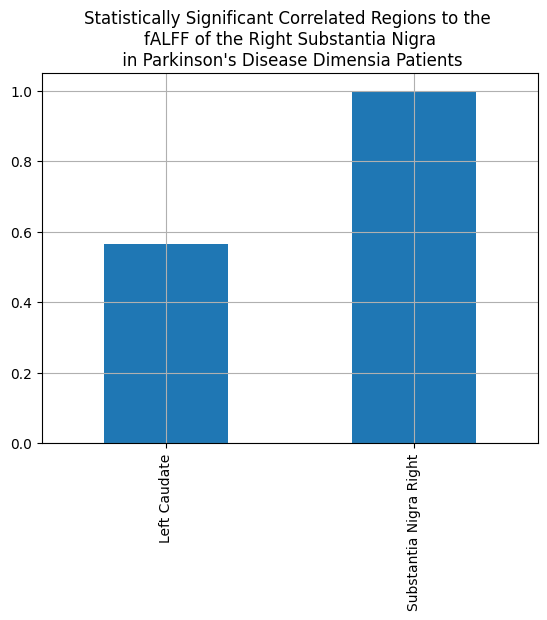

In [235]:
PDD_df.shape
std = np.std(PDD_df.corr()["Substantia Nigra Right"].values)
diff = PDD_df.corr()["Substantia Nigra Right"] - 1
z_score_l = diff / std

# Significance level (usually 0.05 for 95% confidence)
alpha = 0.05

# Calculate the critical value for a two-tailed test (for 95% confidence)
critical_value = norm.ppf(1 - alpha / 2)
critical_value

# Print the critical value
print(f"Critical value (for 95% confidence): {critical_value:.4f}")
stat_sig_l_pdd = []
# Check if the Z-score is greater than the critical value
for z_score in z_score_l:
    if abs(z_score) > critical_value:
        # print("The difference is statistically significant.")
        stat_sig_l_pdd.append(1)
    else:
        # print("The difference is not statistically significant.")
        stat_sig_l_pdd.append(0)
region_list = PDD_df.columns.values
stat_sig_l_pdd_df = pd.DataFrame(stat_sig_l_pdd, region_list, columns=["PDD SN Corr"])
statistically_significant_regions_pdd = stat_sig_l_pdd_df[stat_sig_l_pdd_df["PDD SN Corr"] == 0].index.values
PDD_df.corr()["Substantia Nigra Right"][statistically_significant_regions_pdd].plot(kind='bar')
plt.title("Statistically Significant Correlated Regions to the \nfALFF of the Right Substantia Nigra\n in Parkinson's Disease Dimensia Patients")
plt.grid(True)

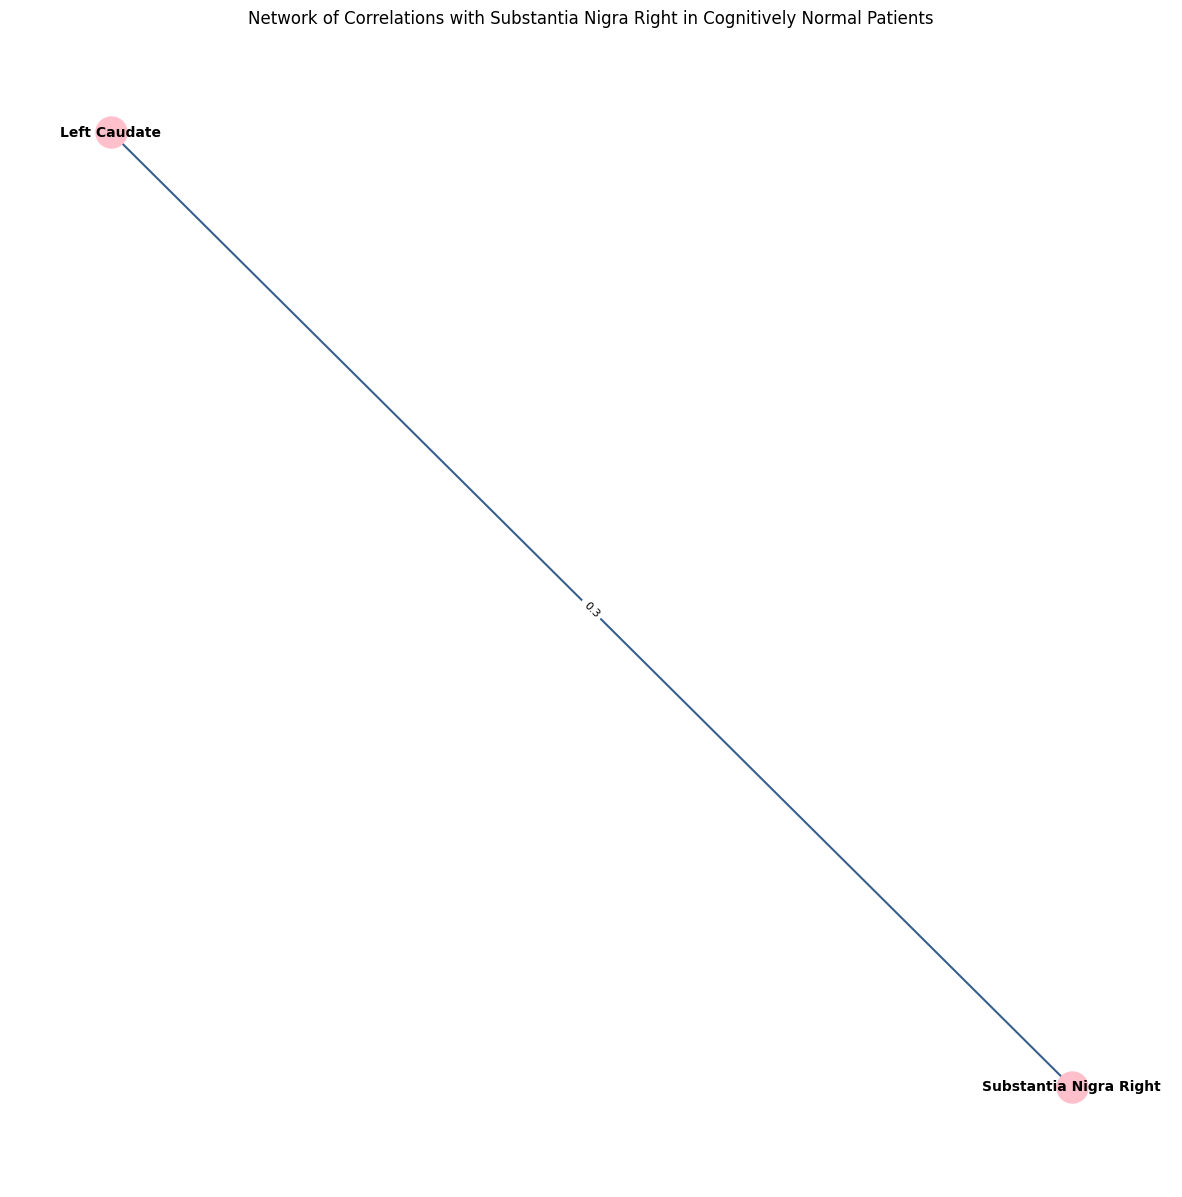

In [ ]:
pdd_edge_correlations = cognitively_normal_df.corr()["Substantia Nigra Right"][statistically_significant_regions_pdd][:-1].values
pdd_nodes = cognitively_normal_df.corr()["Substantia Nigra Right"][statistically_significant_regions_pdd].index.values
pdd_stat_sign_corr_graph = nx.Graph()
pdd_stat_sign_corr_graph.add_nodes_from(pdd_nodes)
for index, node in enumerate(pdd_nodes[:-1]):
    pdd_stat_sign_corr_graph.add_edge(node, "Substantia Nigra Right", weight=pdd_edge_correlations[index])

# Prepare the edge weights, thickness, and colors
edge_weights = [data['weight'] for _, _, data in pdd_stat_sign_corr_graph.edges(data=True)]
edge_thickness = [weight * 5 for weight in edge_weights]  # Scaling for better visibility
edge_colors = [cm.viridis(weight) for weight in edge_weights]  # Using a colormap for colors

# Draw the graph
pdd_pos = nx.spring_layout(pdd_stat_sign_corr_graph, seed=42)  # Positioning of nodes
plt.figure(figsize=(15, 15))

# Draw nodes
nx.draw_networkx_nodes(pdd_stat_sign_corr_graph, pdd_pos, node_size=500, node_color='pink')

# Draw edges with weights (correlations)
edges = pdd_stat_sign_corr_graph.edges(data=True)
nx.draw_networkx_edges(pdd_stat_sign_corr_graph, pdd_pos, edgelist=edges, width=edge_thickness, edge_color=edge_colors)

# Draw labels
nx.draw_networkx_labels(pdd_stat_sign_corr_graph, pdd_pos, font_size=10, font_weight='bold')

# Add edge labels for correlations
edge_labels = {(node, 'Substantia Nigra Right'): f'{round(weight["weight"], 2)}' for node, _, weight in edges}
nx.draw_networkx_edge_labels(pdd_stat_sign_corr_graph, pdd_pos, edge_labels=edge_labels, font_size=8)

# Show plot
plt.title("Network of Correlations with Substantia Nigra Right in Cognitively Normal Patients")
plt.axis('off')
plt.show()

## Combining the graphs for a single representation

In [381]:
pdd_edge_correlations = cognitively_normal_df.corr()["Substantia Nigra Right"][statistically_significant_regions_pdd][:-1].values
pdd_edge_correlations
# Prepare the edge weights, thickness, and colors
pdd_edge_weights = [data['weight'] for _, _, data in pdd_stat_sign_corr_graph.edges(data=True)]
pdd_edge_thickness = [weight * 5 for weight in edge_weights]  # Scaling for better visibility
pdd_edge_colors = [cm.viridis(weight) for weight in edge_weights]  # Using a colormap for colors

In [382]:
edge_correlations = cognitively_normal_df.corr()["Substantia Nigra Right"][statistically_significant_regions_cog_normal][:-1].values
edge_correlations = np.append(edge_correlations, pdd_edge_correlations[0])


In [383]:
nodes = cognitively_normal_df.corr()["Substantia Nigra Right"][statistically_significant_regions_cog_normal].index.values
nodes = np.append(nodes, "Left Caudate")

In [384]:
nodes

array(['Frontal Pole', 'Middle Frontal Gyrus',
       'Superior Temporal Gyrus, posterior division',
       'Middle Temporal Gyrus, anterior division',
       'Middle Temporal Gyrus, posterior division',
       'Supramarginal Gyrus, anterior division',
       'Supramarginal Gyrus, posterior division', 'Angular Gyrus',
       'Frontal Opercular Cortex', 'Supracalcarine Cortex',
       'Left Accumbens', 'Substantia Nigra Right', 'Left Caudate'],
      dtype=object)

In [386]:
cognitively_normal_stat_sign_corr_graph = nx.Graph()
cognitively_normal_stat_sign_corr_graph.add_nodes_from(nodes)
edge_nodes = [node for node in nodes if node != "Substantia Nigra Right"]
for index, node in enumerate(edge_nodes):
        cognitively_normal_stat_sign_corr_graph.add_edge(node, "Substantia Nigra Right", weight=edge_correlations[index])

#### Adding PDD Graph Data

In [ ]:
# Prepare the edge weights, thickness, and colors
edge_weights = [data['weight'] for _, _, data in cognitively_normal_stat_sign_corr_graph.edges(data=True)]
edge_thickness = [weight * 5 for weight in edge_weights]  # Scaling for better visibility
edge_colors = [cm.viridis(weight) for weight in edge_weights]  # Using a colormap for colors
edge_colors[-1] = (pdd_edge_correlations[0], 0, 0, 1) # modifying the color of the PDD group correlation
# Set the default color for nodes
node_colors = ['green' if node != 'Left Caudate' else 'red' for node in cognitively_normal_stat_sign_corr_graph.nodes]

In [453]:
cognitively_normal_stat_sign_corr_graph.nodes

NodeView(('Frontal Pole', 'Middle Frontal Gyrus', 'Superior Temporal Gyrus, posterior division', 'Middle Temporal Gyrus, anterior division', 'Middle Temporal Gyrus, posterior division', 'Supramarginal Gyrus, anterior division', 'Supramarginal Gyrus, posterior division', 'Angular Gyrus', 'Frontal Opercular Cortex', 'Supracalcarine Cortex', 'Left Accumbens', 'Substantia Nigra Right', 'Left Caudate'))

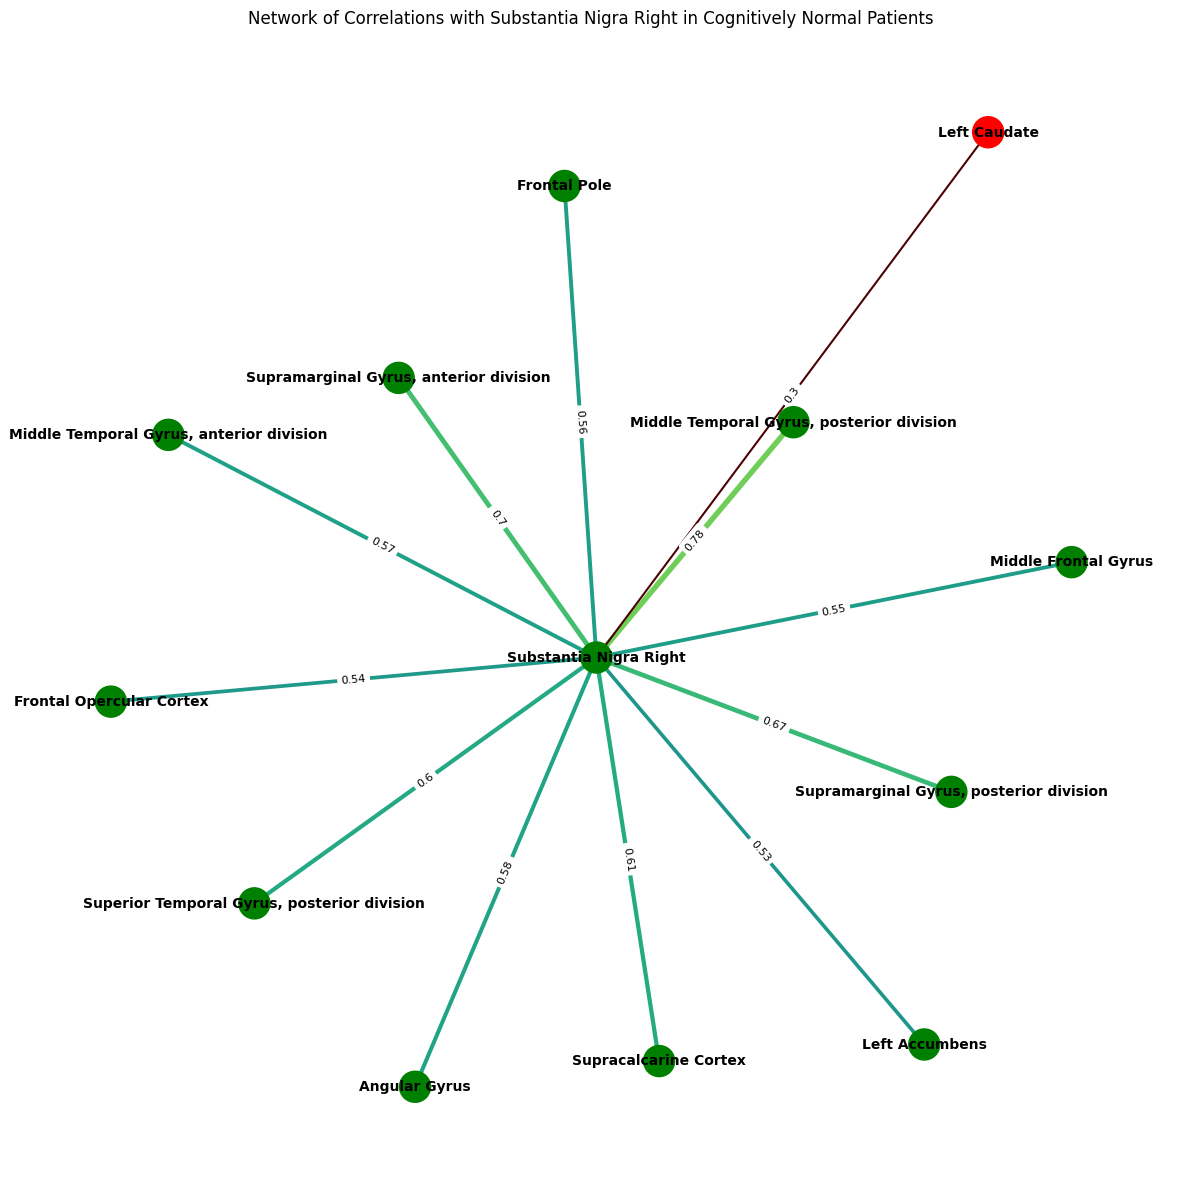

In [452]:

# Draw the graph
pos = nx.spring_layout(cognitively_normal_stat_sign_corr_graph, seed=42)  # Positioning of nodes
plt.figure(figsize=(15, 15))

# Draw nodes
nx.draw_networkx_nodes(cognitively_normal_stat_sign_corr_graph, pos, node_size=500, node_color=node_colors)

# Draw edges with weights (correlations)
edges = cognitively_normal_stat_sign_corr_graph.edges(data=True)
nx.draw_networkx_edges(cognitively_normal_stat_sign_corr_graph, pos, edgelist=edges, width=edge_thickness, edge_color=edge_colors)

# Draw labels
nx.draw_networkx_labels(cognitively_normal_stat_sign_corr_graph, pos, font_size=10, font_weight='bold')

# Add edge labels for correlations
# Create edge labels with the weight rounded to 2 decimal places, and handle the "Substantia Nigra Right" special case
edge_labels = {
    (node if node != "Substantia Nigra Right" else "Left Caudate", 'Substantia Nigra Right'): f'{round(weight["weight"], 2)}' 
    for node, _, weight in cognitively_normal_stat_sign_corr_graph.edges(data=True)
}

nx.draw_networkx_edge_labels(cognitively_normal_stat_sign_corr_graph, pos, edge_labels=edge_labels, font_size=8)

# Show plot
plt.title("Network of Correlations with Substantia Nigra Right in Cognitively Normal Patients")
plt.axis('off')
plt.show()

In [454]:
import json

data = nx.node_link_data(cognitively_normal_stat_sign_corr_graph)  # Convert to a dictionary
with open("../data/graphs/cognitively_normal_pdd_stat_sign_corr_graph.json", "w") as f:
    json.dump(data, f, indent=4)


/home/linux-pc/anaconda3/envs/torch/lib/python3.10/site-packages/networkx/readwrite/json_graph/node_link.py:142: FutureWarning: 
The default value will be `edges="edges" in NetworkX 3.6.

To make this warning go away, explicitly set the edges kwarg, e.g.:

  nx.node_link_data(G, edges="links") to preserve current behavior, or
  nx.node_link_data(G, edges="edges") for forward compatibility.
  warnings.warn(


# Back-of-Envelope-Calc

In [ ]:
cognitively_normal_df["Substantia Nigra Right"].mean()

0.00960811897221647

In [198]:
MCI_df["Substantia Nigra Right"].mean()

0.0075297651099400665

In [199]:
PDD_df["Substantia Nigra Right"].mean()

0.006212387712529779

In [200]:
cognitively_normal_df["Substantia Nigra Right"].mean() - MCI_df["Substantia Nigra Right"].mean()

0.002078353862276403

In [201]:
cognitively_normal_df["Substantia Nigra Right"].mean() - PDD_df["Substantia Nigra Right"].mean()

0.0033957312596866905

In [ ]:
cognitively_normal_df.loc[:, statistically_significant_regions_cog_normal]

,Frontal Pole,Middle Frontal Gyrus,"Superior Temporal Gyrus, posterior division","Middle Temporal Gyrus, anterior division","Middle Temporal Gyrus, posterior division","Supramarginal Gyrus, anterior division","Supramarginal Gyrus, posterior division",Angular Gyrus,Frontal Opercular Cortex,Supracalcarine Cortex,Left Accumbens,Substantia Nigra Right
1,0.008063,0.008537,0.008496,0.008455,0.008690,0.008619,0.008552,0.008523,0.007957,0.008139,0.008421,0.008675
5,0.011054,0.010952,0.011587,0.010792,0.011346,0.011440,0.011316,0.010763,0.007580,0.009098,0.009090,0.009469
10,0.011432,0.010852,0.010228,0.011034,0.010514,0.011689,0.011868,0.010897,0.009771,0.008495,0.010146,0.009458
11,0.011988,0.011652,0.011318,0.012106,0.011354,0.010601,0.010398,0.011366,0.009490,0.009634,0.010057,0.009110
12,0.009582,0.009996,0.009458,0.007505,0.009394,0.010320,0.010731,0.011382,0.010089,0.008347,0.006965,0.008290
19,0.011439,0.009081,0.008511,0.008483,0.009885,0.010081,0.010173,0.009213,0.008607,0.009215,0.010712,0.009090
22,0.013064,0.012319,0.011528,0.012298,0.011990,0.011951,0.012081,0.011715,0.010920,0.010625,0.011407,0.009984
29,0.012712,0.012615,0.011506,0.011806,0.012318,0.011560,0.011740,0.012244,0.009961,0.010915,0.011503,0.010622
33,0.009198,0.009986,0.011201,0.012080,0.012180,0.012880,0.011410,0.011946,0.010064,0.012208,0.010016,0.010205
43,0.010682,0.012008,0.010266,0.011188,0.011492,0.011679,0.012236,0.012005,0.010205,0.013116,0.008632,0.009621


In [152]:
region_list

array(['Frontal Pole', 'Insular Cortex', 'Superior Frontal Gyrus',
       'Middle Frontal Gyrus',
       'Inferior Frontal Gyrus, pars triangularis',
       'Inferior Frontal Gyrus, pars opercularis', 'Precentral Gyrus',
       'Temporal Pole', 'Superior Temporal Gyrus, anterior division',
       'Superior Temporal Gyrus, posterior division',
       'Middle Temporal Gyrus, anterior division',
       'Middle Temporal Gyrus, posterior division',
       'Middle Temporal Gyrus, temporooccipital part',
       'Inferior Temporal Gyrus, anterior division',
       'Inferior Temporal Gyrus, posterior division',
       'Inferior Temporal Gyrus, temporooccipital part',
       'Postcentral Gyrus', 'Superior Parietal Lobule',
       'Supramarginal Gyrus, anterior division',
       'Supramarginal Gyrus, posterior division', 'Angular Gyrus',
       'Lateral Occipital Cortex, superior division',
       'Lateral Occipital Cortex, inferior division',
       'Intracalcarine Cortex', 'Frontal Medial Corte

In [137]:
cognitively_normal_df

,Frontal Pole,Insular Cortex,Superior Frontal Gyrus,Middle Frontal Gyrus,"Inferior Frontal Gyrus, pars triangularis","Inferior Frontal Gyrus, pars opercularis",Precentral Gyrus,Temporal Pole,"Superior Temporal Gyrus, anterior division","Superior Temporal Gyrus, posterior division",...,Right Lateral Ventricle,Right Thalamus,Right Caudate,Right Putamen,Right Pallidum,Right Hippocampus,Right Amygdala,Right Accumbens,Substantia Nigra Right,Substantia Nigra Left
1,0.008063,0.008100,0.008432,0.008537,0.008519,0.008345,0.008678,0.007926,0.008483,0.008496,...,0.007906,0.007987,0.007816,0.008021,0.008095,0.008172,0.009426,0.009352,0.008675,0.010451
5,0.011054,0.009669,0.009777,0.010952,0.010490,0.010208,0.011544,0.007987,0.010900,0.011587,...,0.008534,0.009586,0.010081,0.010380,0.010627,0.008550,0.007665,0.008840,0.009469,0.008834
10,0.011432,0.010519,0.010559,0.010852,0.011494,0.010772,0.011937,0.008906,0.009679,0.010228,...,0.009429,0.009748,0.009579,0.010118,0.008442,0.010483,0.010338,0.008454,0.009458,0.007541
11,0.011988,0.010943,0.012324,0.011652,0.013087,0.011085,0.011636,0.011237,0.012247,0.011318,...,0.010646,0.011025,0.011456,0.009673,0.011321,0.010177,0.010740,0.012046,0.009110,0.007964
12,0.009582,0.011586,0.010148,0.009996,0.011123,0.012583,0.011788,0.010706,0.011249,0.009458,...,0.007008,0.006526,0.007824,0.010595,0.008486,0.010765,0.010828,0.008979,0.008290,0.008631
19,0.011439,0.008667,0.009668,0.009081,0.010115,0.009630,0.009017,0.010385,0.009304,0.008511,...,0.009504,0.006775,0.009577,0.009175,0.010412,0.009203,0.009123,0.010989,0.009090,0.009002
22,0.013064,0.012224,0.012532,0.012319,0.012716,0.012213,0.012385,0.012769,0.010508,0.011528,...,0.010884,0.010729,0.011401,0.011973,0.010967,0.012079,0.011361,0.009650,0.009984,0.008965
29,0.012712,0.012324,0.012464,0.012615,0.012317,0.012592,0.012346,0.012415,0.010973,0.011506,...,0.010525,0.007405,0.010891,0.010679,0.011657,0.007493,0.008228,0.011317,0.010622,0.007588
33,0.009198,0.010416,0.010286,0.009986,0.011022,0.010454,0.011911,0.009739,0.010440,0.011201,...,0.007626,0.009222,0.006492,0.009862,0.007670,0.007849,0.009706,0.007572,0.010205,0.007509
43,0.010682,0.012809,0.011520,0.012008,0.011517,0.011373,0.013436,0.011490,0.011356,0.010266,...,0.007508,0.011688,0.009054,0.009599,0.008703,0.009407,0.007968,0.008849,0.009621,0.007092


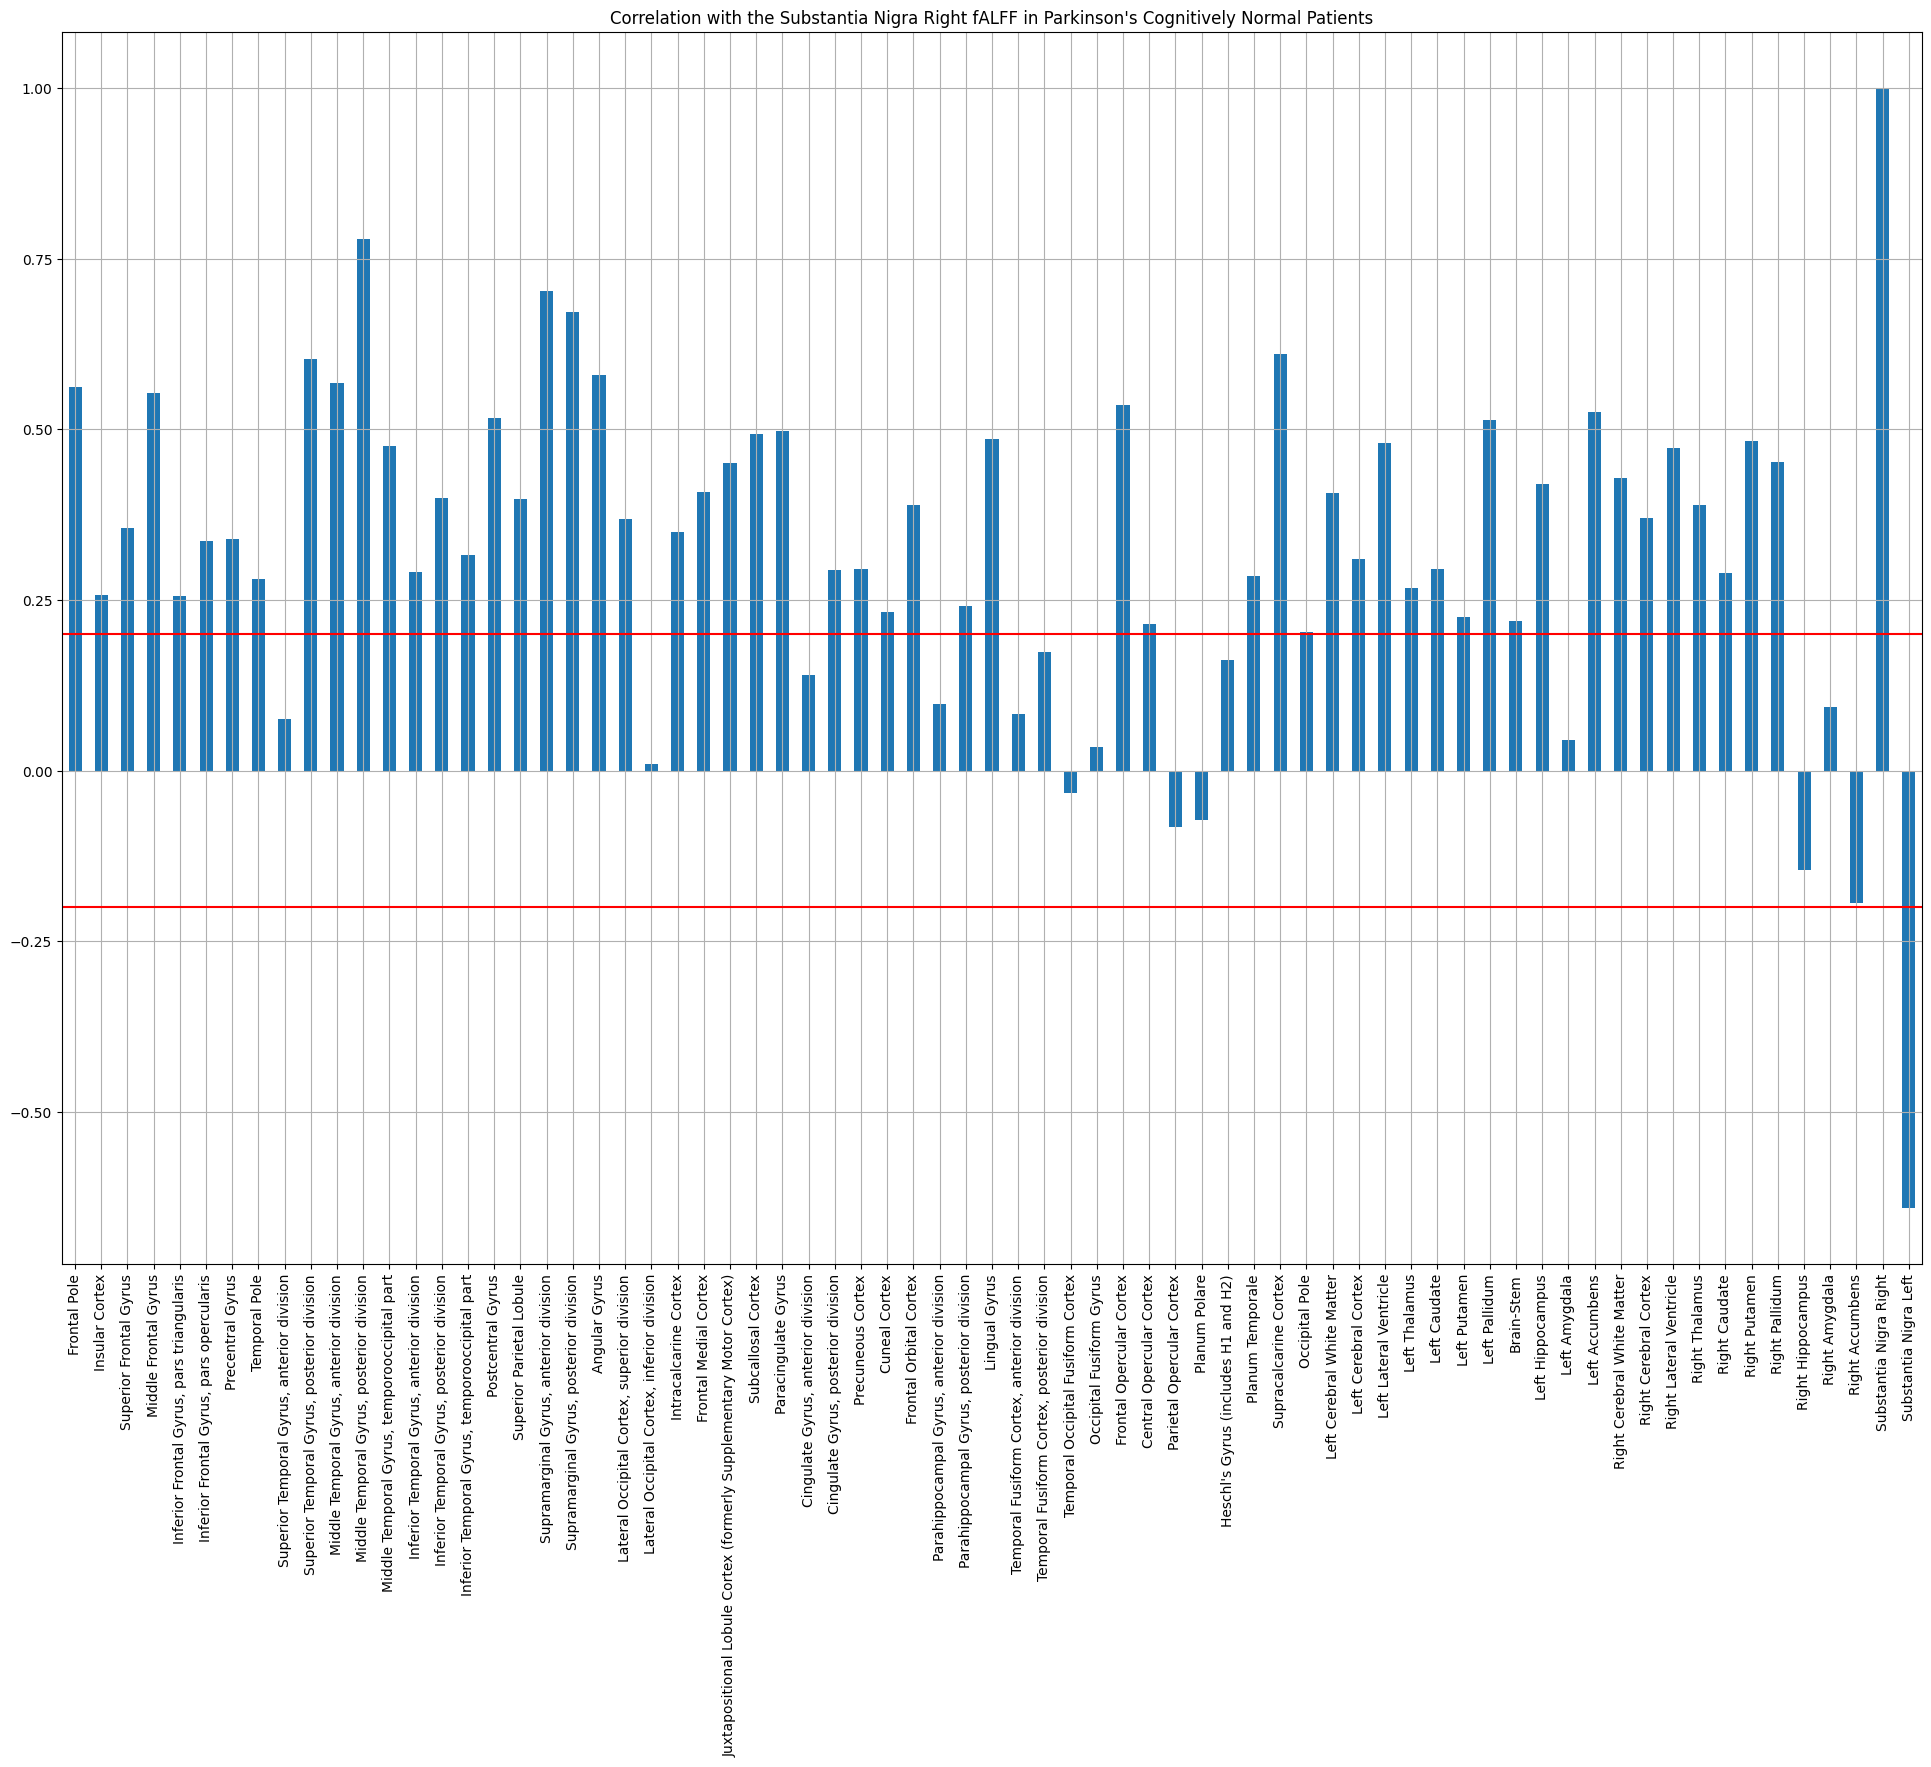

In [111]:
plot_snr_corr(cognitively_normal_df, "Cognitively Normal", cut_off_pos=0.2)

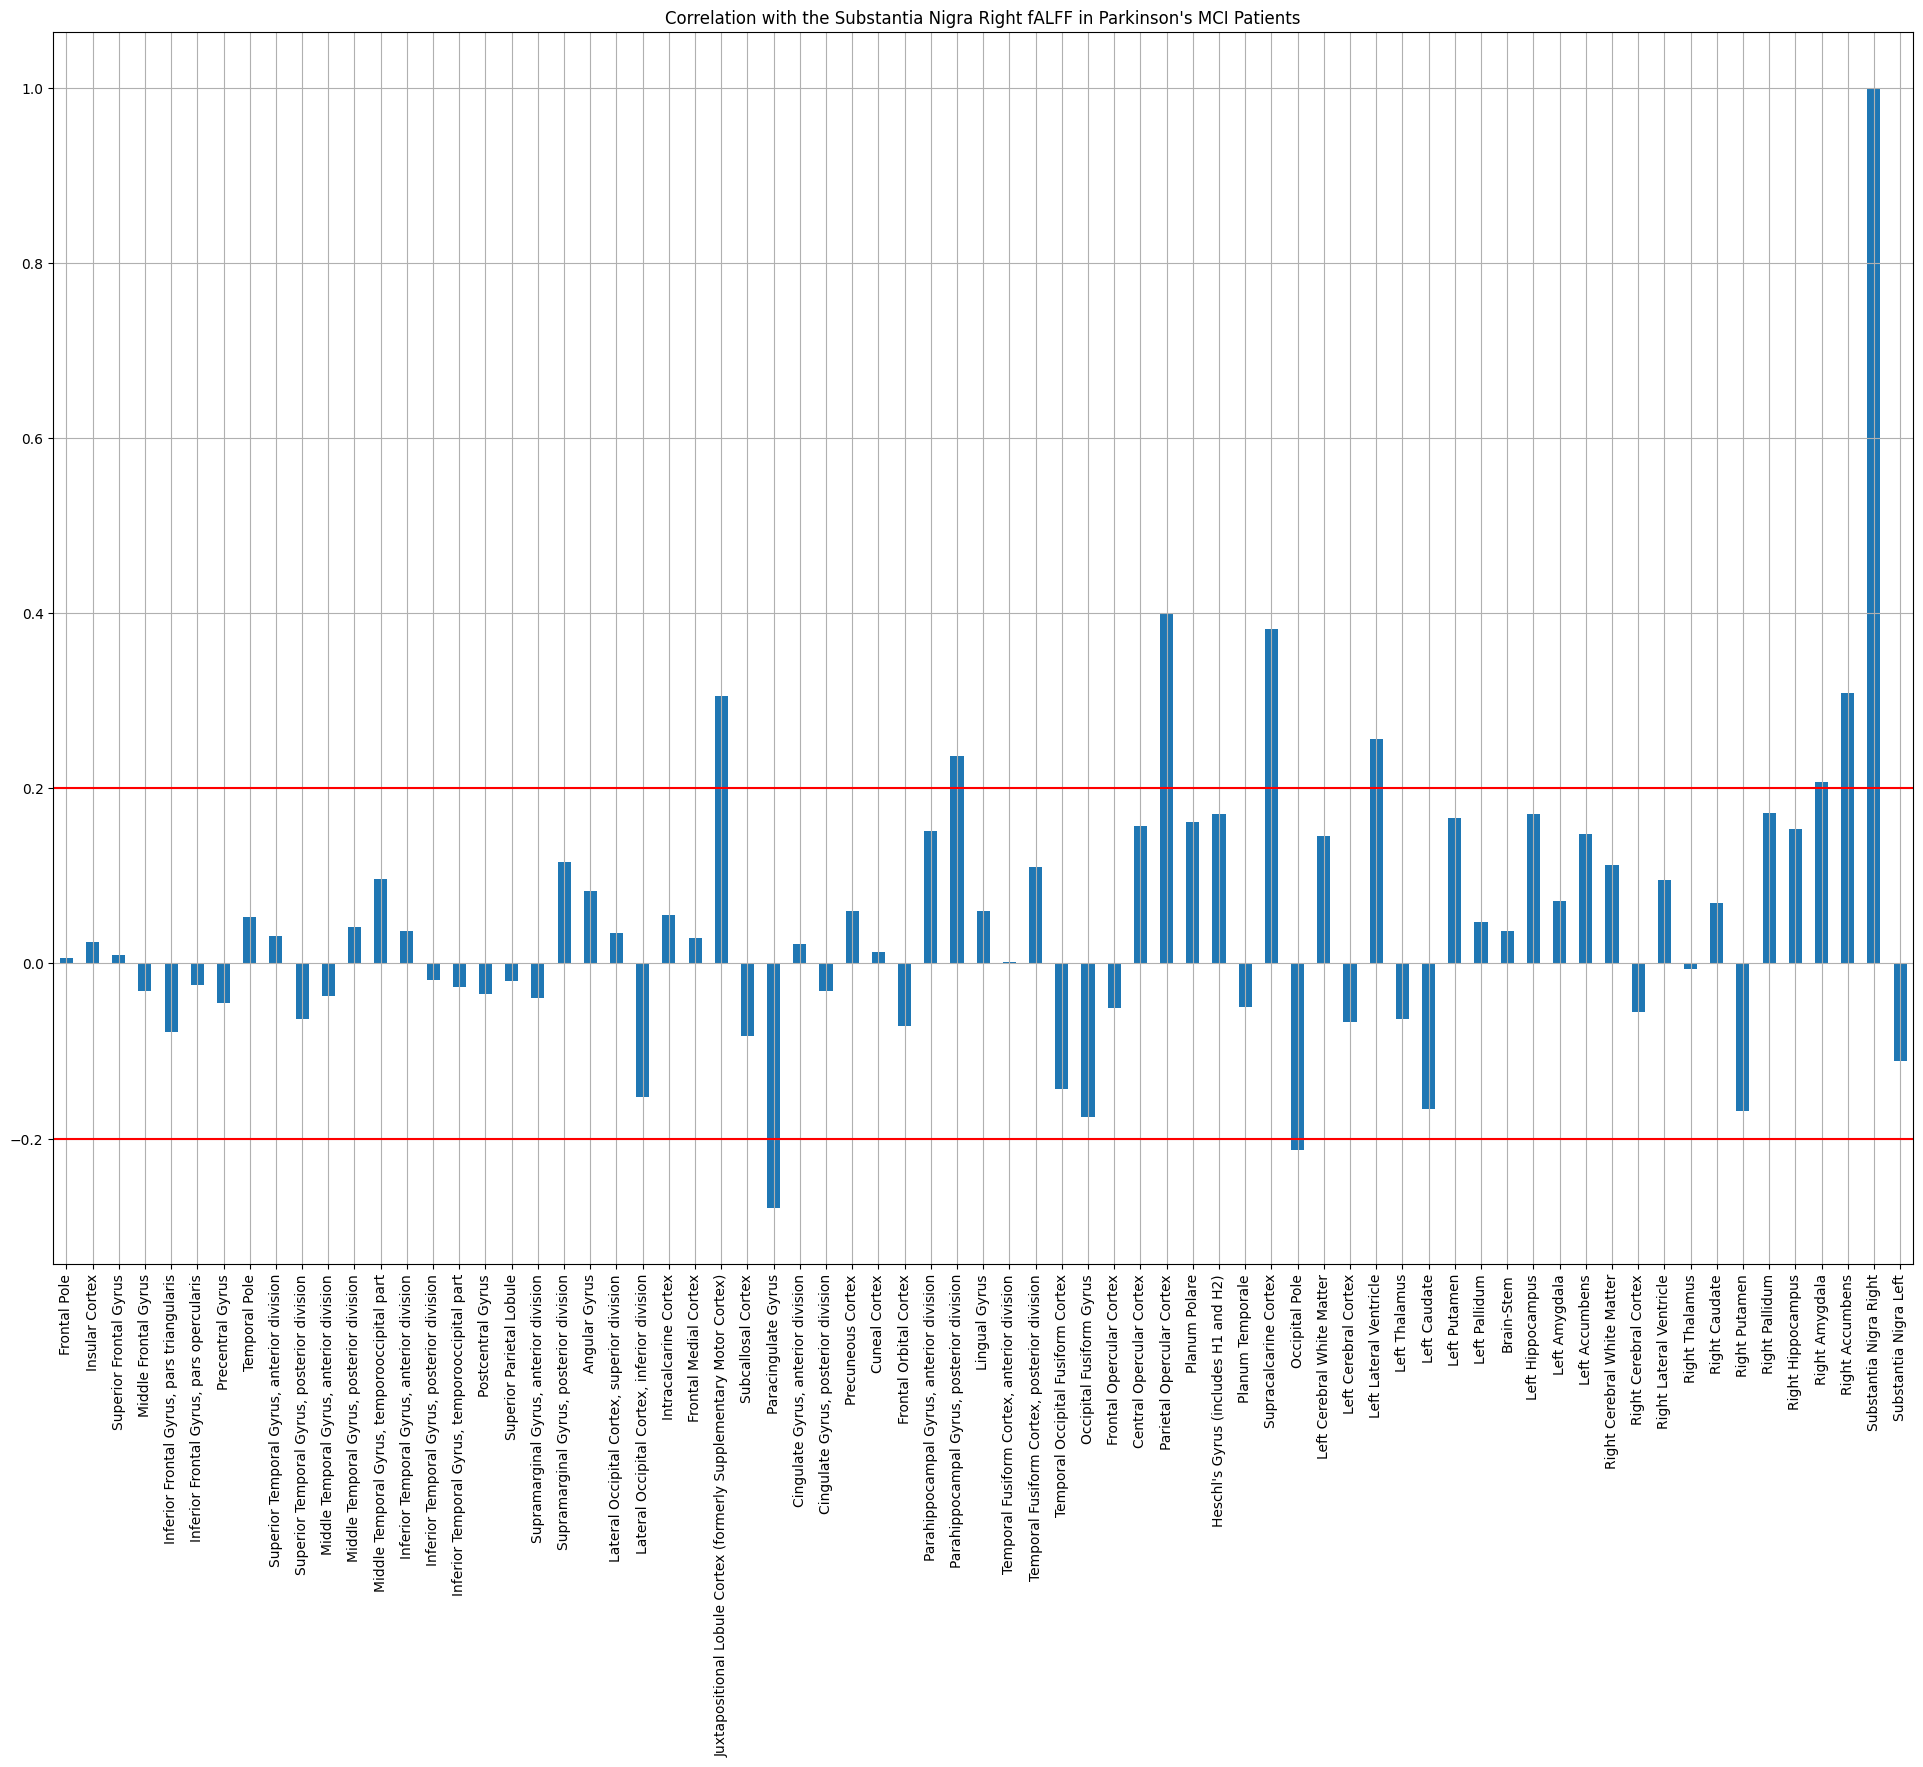

In [112]:
plot_snr_corr(MCI_df, "MCI")

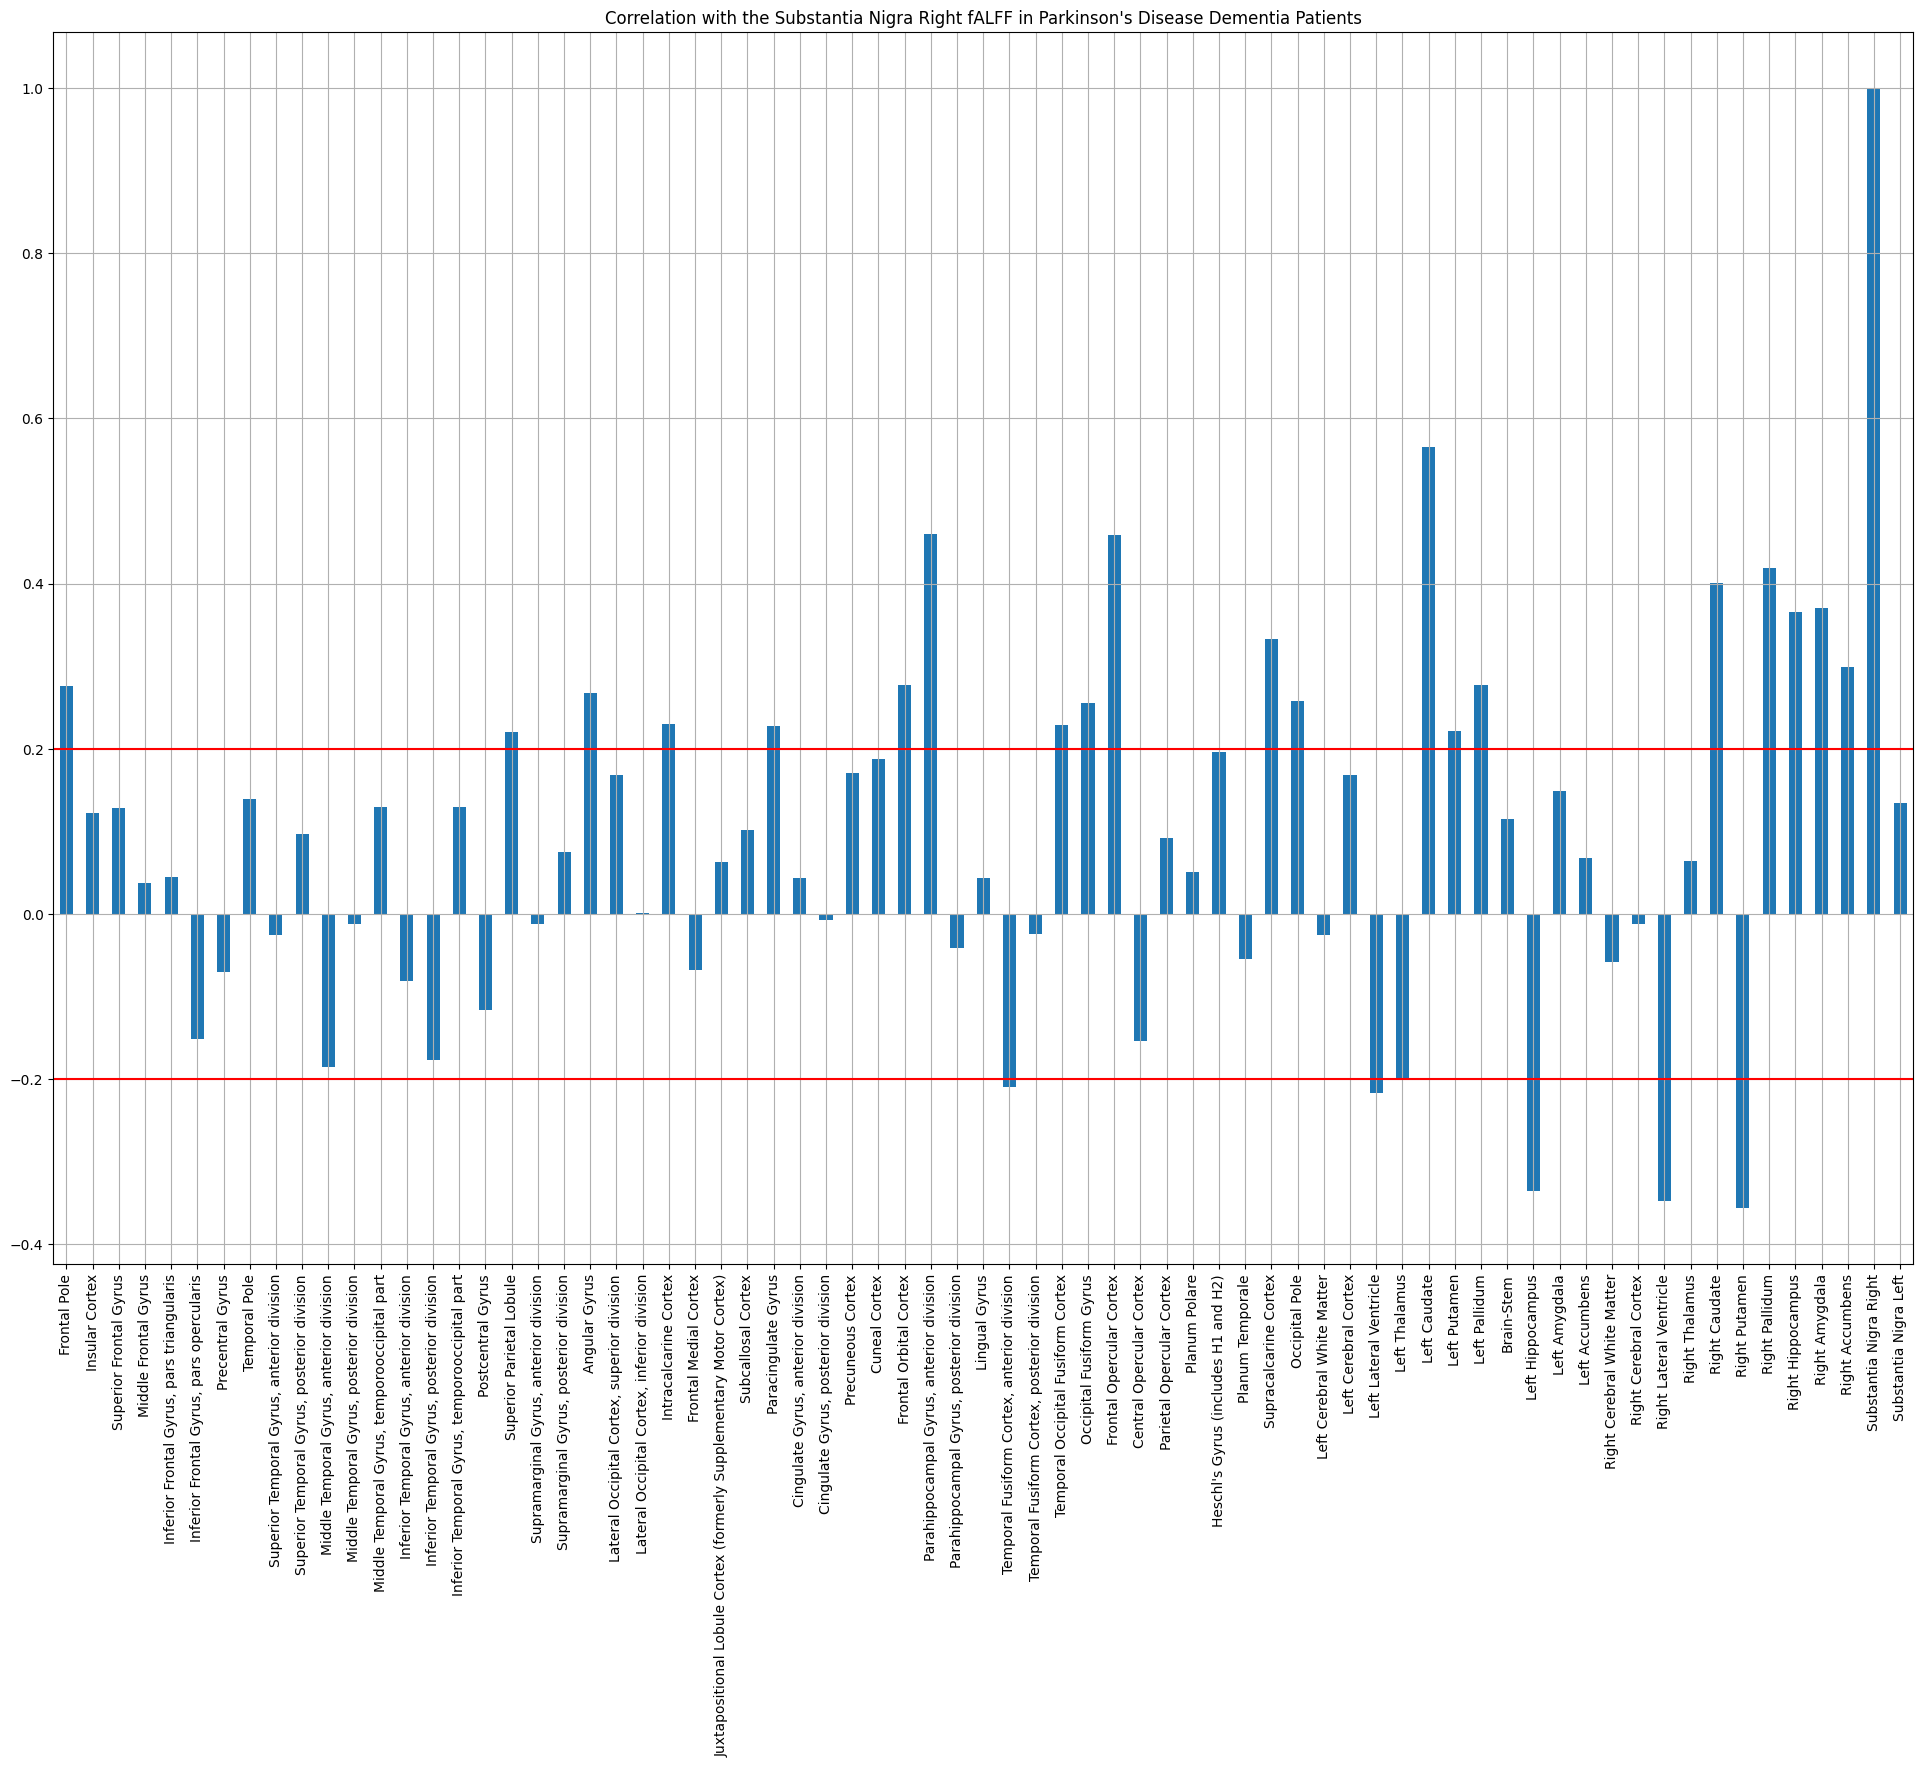

In [113]:
plot_snr_corr(PDD_df, "Disease Dementia")

In [ ]:
cognitively_normal_typical = fALFF_df_imputed_clustered.iloc[10,:].copy()
cognitively_normal_typical = pd.DataFrame(cognitively_normal_typical)
cognitively_normal_typical.rename(columns={10:"Cognitively Normal Typical fALFF"}, inplace=True)
cognitively_normal_typical = cognitively_normal_typical.T.drop(columns=["cluster"])
cognitively_normal_typical = cognitively_normal_typical.T
cognitively_normal_typical

,Cognitively Normal Typical fALFF
Frontal Pole,0.011432
Insular Cortex,0.010519
Superior Frontal Gyrus,0.010559
Middle Frontal Gyrus,0.010852
"Inferior Frontal Gyrus, pars triangularis",0.011494
...,...
Right Hippocampus,0.010483
Right Amygdala,0.010338
Right Accumbens,0.008454
Substantia Nigra Right,0.009458


In [21]:
cognitively_normal_typical["Cognitively Normal Typical fALFF"].mean()

0.010519431087167156

In [22]:
abs(cognitively_normal_typical["Cognitively Normal Typical fALFF"] - cognitively_normal_typical["Cognitively Normal Typical fALFF"].mean())

Frontal Pole                                 9.128621e-04
Insular Cortex                               2.548696e-07
Superior Frontal Gyrus                       3.967234e-05
Middle Frontal Gyrus                         3.324713e-04
Inferior Frontal Gyrus, pars triangularis    9.742037e-04
                                                 ...     
Right Hippocampus                            3.654770e-05
Right Amygdala                               1.811467e-04
Right Accumbens                              2.065295e-03
Substantia Nigra Right                       1.061094e-03
Substantia Nigra Left                        2.978174e-03
Name: Cognitively Normal Typical fALFF, Length: 71, dtype: float64

In [23]:
cognitively_normal_typical.loc["Substantia Nigra Right"]

Cognitively Normal Typical fALFF    0.009458
Name: Substantia Nigra Right, dtype: float64

In [24]:
snr_falff_cn = pd.DataFrame(np.full(71, cognitively_normal_typical.loc["Substantia Nigra Right"]), columns=["Substantia Nigra Right Cognitively Normal"])

In [25]:
snr_falff_cn

,Substantia Nigra Right Cognitively Normal
0,0.009458
1,0.009458
2,0.009458
3,0.009458
4,0.009458
...,...
66,0.009458
67,0.009458
68,0.009458
69,0.009458


In [26]:
cognitively_normal_typical.reset_index(inplace=True)

In [27]:
cognitively_normal_typical

,index,Cognitively Normal Typical fALFF
0,Frontal Pole,0.011432
1,Insular Cortex,0.010519
2,Superior Frontal Gyrus,0.010559
3,Middle Frontal Gyrus,0.010852
4,"Inferior Frontal Gyrus, pars triangularis",0.011494
...,...,...
66,Right Hippocampus,0.010483
67,Right Amygdala,0.010338
68,Right Accumbens,0.008454
69,Substantia Nigra Right,0.009458


In [28]:
cognitively_normal_typical = pd.concat([cognitively_normal_typical, snr_falff_cn], axis=1)

In [29]:
cognitively_normal_typical

,index,Cognitively Normal Typical fALFF,Substantia Nigra Right Cognitively Normal
0,Frontal Pole,0.011432,0.009458
1,Insular Cortex,0.010519,0.009458
2,Superior Frontal Gyrus,0.010559,0.009458
3,Middle Frontal Gyrus,0.010852,0.009458
4,"Inferior Frontal Gyrus, pars triangularis",0.011494,0.009458
...,...,...,...
66,Right Hippocampus,0.010483,0.009458
67,Right Amygdala,0.010338,0.009458
68,Right Accumbens,0.008454,0.009458
69,Substantia Nigra Right,0.009458,0.009458


In [245]:
cosine_similarity_matrix = cosine_similarity(cognitively_normal_typical.loc[:, ["Cognitively Normal Typical fALFF", "Substantia Nigra Right Cognitively Normal"]])

In [246]:
cognitively_normal_typical

,index,Cognitively Normal Typical fALFF,Substantia Nigra Right Cognitively Normal
0,Frontal Pole,0.011432,0.009458
1,Insular Cortex,0.010519,0.009458
2,Superior Frontal Gyrus,0.010559,0.009458
3,Middle Frontal Gyrus,0.010852,0.009458
4,"Inferior Frontal Gyrus, pars triangularis",0.011494,0.009458
...,...,...,...
66,Right Hippocampus,0.010483,0.009458
67,Right Amygdala,0.010338,0.009458
68,Right Accumbens,0.008454,0.009458
69,Substantia Nigra Right,0.009458,0.009458


In [247]:
sn_cosine_similarity = pd.DataFrame(cosine_similarity_matrix).iloc[69, :]

In [248]:
sn_cosine_similarity = pd.Series(sn_cosine_similarity)

In [249]:
sn_cosine_similarity.name = "SN Cos Sim"

In [250]:
abs_diff_sn = pd.Series(abs(cognitively_normal_typical["Cognitively Normal Typical fALFF"] - cognitively_normal_typical["Substantia Nigra Right Cognitively Normal"]))

In [251]:
abs_diff_sn.name = "SN Absolute Difference"

In [252]:
abs_diff_mean = pd.Series(abs(cognitively_normal_typical["Cognitively Normal Typical fALFF"] - cognitively_normal_typical["Cognitively Normal Typical fALFF"].mean()))

In [253]:
abs_diff_mean.name = "Mean Absolute Difference"

In [254]:
cognitively_normal_typical = pd.concat([cognitively_normal_typical, sn_cosine_similarity, abs_diff_sn, abs_diff_mean], axis=1)

In [ ]:
# cognitively_normal_typical.to_csv("../data/dataframes/cognitively_normal/cognitively_normal_typical.csv", index=False)

## Visualizing Cognitively Normal Metrics

In [263]:
cogn_t_df = pd.read_csv("../data/dataframes/cognitively_normal/cognitively_normal_typical.csv")

In [265]:
cogn_t_df

,index,Cognitively Normal Typical fALFF,Substantia Nigra Right Cognitively Normal,SN Cos Sim,SN Absolute Difference,Mean Absolute Difference
0,Frontal Pole,0.011432,0.009458,0.995565,0.001974,9.128621e-04
1,Insular Cortex,0.010519,0.009458,0.998593,0.001061,2.548696e-07
2,Superior Frontal Gyrus,0.010559,0.009458,0.998491,0.001101,3.967234e-05
3,Middle Frontal Gyrus,0.010852,0.009458,0.997654,0.001394,3.324713e-04
4,"Inferior Frontal Gyrus, pars triangularis",0.011494,0.009458,0.995315,0.002035,9.742037e-04
...,...,...,...,...,...,...
66,Right Hippocampus,0.010483,0.009458,0.998683,0.001025,3.654770e-05
67,Right Amygdala,0.010338,0.009458,0.999014,0.000880,1.811467e-04
68,Right Accumbens,0.008454,0.009458,0.998432,0.001004,2.065295e-03
69,Substantia Nigra Right,0.009458,0.009458,1.000000,0.000000,1.061094e-03


In [ ]:
cogn_t_df[cogn_t_df["index"] == "Frontal Pole"]

0    0.995565
Name: SN Cos Sim, dtype: float64

In [272]:
metric = "SN Cos Sim"
cogn_t_graph_cos_sim = nx.Graph()
cogn_t_graph_cos_sim.add_nodes_from(cogn_t_df["index"])
snr = "Substantia Nigra Right"
# Add edges from 'Substantia Nigra Right' to all other nodes
for node in cogn_t_graph_cos_sim.nodes():
    if node != snr:  # Avoid adding self-loop to the same node
        cogn_t_graph_cos_sim.add_edge(snr, node, weight = cogn_t_df[cogn_t_df["index"] == node][metric])






In [288]:
for u, v in cogn_t_graph_cos_sim.edges():
    print(cogn_t_graph_cos_sim[u][v]['weight'].values)

[0.99556549]
[0.99859308]
[0.99849145]
[0.99765434]
[0.99531494]
[0.99789921]
[0.9933552]
[0.99954733]
[0.99993376]
[0.99923652]
[0.99705642]
[0.99860724]
[0.9999692]
[0.99876646]
[0.99927511]
[0.99844229]
[0.99030794]
[0.99690519]
[0.99448086]
[0.9936757]
[0.99751016]
[0.99745144]
[0.99309105]
[0.99021158]
[0.9945343]
[0.99729231]
[0.99879298]
[0.99793345]
[0.99976394]
[0.99534112]
[0.99033053]
[0.99996302]
[0.99755898]
[0.99986698]
[0.99973519]
[0.9943035]
[0.9999844]
[0.99937228]
[0.99791201]
[0.99814372]
[0.99986793]
[0.99778178]
[0.9989814]
[0.9998859]
[0.99943717]
[0.99734971]
[0.99856366]
[0.99915014]
[0.99430677]
[0.99500393]
[0.99879953]
[0.99963348]
[0.99830281]
[0.9956278]
[0.99958379]
[0.99550452]
[0.99974754]
[0.99936584]
[0.99938609]
[0.99255728]
[0.99627609]
[0.99999879]
[0.99988646]
[0.99997986]
[0.99943225]
[0.99839304]
[0.99868274]
[0.99901359]
[0.99843225]
[0.99370124]


In [292]:
edges =[cogn_t_graph_cos_sim[u][v]['weight'].values for u, v in cogn_t_graph_cos_sim.edges()]

In [293]:
edges = np.array(edges)

In [298]:
edges = edges.flatten()

In [299]:
edges

array([0.99556549, 0.99859308, 0.99849145, 0.99765434, 0.99531494,
       0.99789921, 0.9933552 , 0.99954733, 0.99993376, 0.99923652,
       0.99705642, 0.99860724, 0.9999692 , 0.99876646, 0.99927511,
       0.99844229, 0.99030794, 0.99690519, 0.99448086, 0.9936757 ,
       0.99751016, 0.99745144, 0.99309105, 0.99021158, 0.9945343 ,
       0.99729231, 0.99879298, 0.99793345, 0.99976394, 0.99534112,
       0.99033053, 0.99996302, 0.99755898, 0.99986698, 0.99973519,
       0.9943035 , 0.9999844 , 0.99937228, 0.99791201, 0.99814372,
       0.99986793, 0.99778178, 0.9989814 , 0.9998859 , 0.99943717,
       0.99734971, 0.99856366, 0.99915014, 0.99430677, 0.99500393,
       0.99879953, 0.99963348, 0.99830281, 0.9956278 , 0.99958379,
       0.99550452, 0.99974754, 0.99936584, 0.99938609, 0.99255728,
       0.99627609, 0.99999879, 0.99988646, 0.99997986, 0.99943225,
       0.99839304, 0.99868274, 0.99901359, 0.99843225, 0.99370124])

In [308]:
cogn_t_graph_cos_sim.nodes

NodeView(('Frontal Pole', 'Insular Cortex', 'Superior Frontal Gyrus', 'Middle Frontal Gyrus', 'Inferior Frontal Gyrus, pars triangularis', 'Inferior Frontal Gyrus, pars opercularis', 'Precentral Gyrus', 'Temporal Pole', 'Superior Temporal Gyrus, anterior division', 'Superior Temporal Gyrus, posterior division', 'Middle Temporal Gyrus, anterior division', 'Middle Temporal Gyrus, posterior division', 'Middle Temporal Gyrus, temporooccipital part', 'Inferior Temporal Gyrus, anterior division', 'Inferior Temporal Gyrus, posterior division', 'Inferior Temporal Gyrus, temporooccipital part', 'Postcentral Gyrus', 'Superior Parietal Lobule', 'Supramarginal Gyrus, anterior division', 'Supramarginal Gyrus, posterior division', 'Angular Gyrus', 'Lateral Occipital Cortex, superior division', 'Lateral Occipital Cortex, inferior division', 'Intracalcarine Cortex', 'Frontal Medial Cortex', 'Juxtapositional Lobule Cortex (formerly Supplementary Motor Cortex)', 'Subcallosal Cortex', 'Paracingulate Gyru

In [301]:

# Get the weights for color coding and edge thickness
edge_weights =[cogn_t_graph_cos_sim[u][v]['weight'].values for u, v in cogn_t_graph_cos_sim.edges()]
edge_weights = np.array(edge_weights)
edge_weights = edge_weights.flatten()
min_weight = min(edge_weights)
max_weight = max(edge_weights)

# Set up the color map for edge weights
norm = plt.Normalize(vmin=min_weight, vmax=max_weight)
cmap = plt.get_cmap("viridis")


In [304]:
nx.spring_layout(cogn_t_graph_cos_sim.nodes, seed=42)

{'Frontal Pole': array([-0.00321244,  0.98854613]),
 'Insular Cortex': array([0.82377308, 0.44293417]),
 'Superior Frontal Gyrus': array([-0.66528964, -0.75853825]),
 'Middle Frontal Gyrus': array([-0.86643511,  0.54529583]),
 'Inferior Frontal Gyrus, pars triangularis': array([0.39376991, 0.83156802]),
 'Inferior Frontal Gyrus, pars opercularis': array([-0.72139991,  0.77509192]),
 'Precentral Gyrus': array([ 0.77666282, -0.64015403]),
 'Temporal Pole': array([-0.8061623 , -0.57546637]),
 'Superior Temporal Gyrus, anterior division': array([-0.60144279,  0.57608529]),
 'Superior Temporal Gyrus, posterior division': array([ 0.53511398, -0.71589466]),
 'Middle Temporal Gyrus, anterior division': array([ 0.33494927, -0.92549737]),
 'Middle Temporal Gyrus, posterior division': array([-0.83852613, -0.38211191]),
 'Middle Temporal Gyrus, temporooccipital part': array([-0.11006778,  0.92596198]),
 'Inferior Temporal Gyrus, anterior division': array([-0.90716711,  0.2121832 ]),
 'Inferior Tem

In [306]:

# Plot the graph
plt.figure(figsize=(10, 10))

# Draw the nodes
pos = nx.spring_layout(cogn_t_graph_cos_sim, seed=42)  # Positioning the nodes
nx.draw_networkx_nodes(cogn_t_graph_cos_sim, pos, node_size=500, node_color='lightblue')

# Draw the edges with color and thickness based on the weight
nx.draw_networkx_edges(cogn_t_graph_cos_sim, pos,
                       width=[(weight - min_weight) / (max_weight - min_weight) * 10 for weight in edge_weights],  # Edge thickness
                       edge_color=edge_weights, edge_cmap=cmap, alpha=0.7)

# Draw the labels
nx.draw_networkx_labels(cogn_t_graph_cos_sim, pos, font_size=12, font_weight='bold')

# Add color bar for edge weight
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm, label=metric)

# Display the graph
plt.title(f"Graph with {metric} weights")
plt.axis("off")  # Hide the axis
plt.show()

ValueError: shape mismatch: value array of shape (70,1) could not be broadcast to indexing result of shape (70,)

<Figure size 1000x1000 with 0 Axes>

In [305]:
cogn_t_graph_cos_sim.nodes

NodeView(('Frontal Pole', 'Insular Cortex', 'Superior Frontal Gyrus', 'Middle Frontal Gyrus', 'Inferior Frontal Gyrus, pars triangularis', 'Inferior Frontal Gyrus, pars opercularis', 'Precentral Gyrus', 'Temporal Pole', 'Superior Temporal Gyrus, anterior division', 'Superior Temporal Gyrus, posterior division', 'Middle Temporal Gyrus, anterior division', 'Middle Temporal Gyrus, posterior division', 'Middle Temporal Gyrus, temporooccipital part', 'Inferior Temporal Gyrus, anterior division', 'Inferior Temporal Gyrus, posterior division', 'Inferior Temporal Gyrus, temporooccipital part', 'Postcentral Gyrus', 'Superior Parietal Lobule', 'Supramarginal Gyrus, anterior division', 'Supramarginal Gyrus, posterior division', 'Angular Gyrus', 'Lateral Occipital Cortex, superior division', 'Lateral Occipital Cortex, inferior division', 'Intracalcarine Cortex', 'Frontal Medial Cortex', 'Juxtapositional Lobule Cortex (formerly Supplementary Motor Cortex)', 'Subcallosal Cortex', 'Paracingulate Gyru

In [80]:
PDD_typical = fALFF_df_imputed_clustered.iloc[3, :].copy()

In [58]:
MCI_typical = fALFF_df_imputed_clustered.iloc[0, :].copy()

In [66]:
cognitively_normal_typical.drop(columns=["cluster"], inplace=True)

In [67]:
cognitively_normal_typical

Frontal Pole                                 0.011432
Insular Cortex                               0.010519
Superior Frontal Gyrus                       0.010559
Middle Frontal Gyrus                         0.010852
Inferior Frontal Gyrus, pars triangularis    0.011494
                                               ...   
Right Amygdala                               0.010338
Right Accumbens                              0.008454
Substantia Nigra Right                       0.009458
Substantia Nigra Left                        0.007541
cluster                                      2.000000
Name: 10, Length: 72, dtype: float64

In [113]:
cognitively_normal_typical

,Cognitively Normal Typical fALFF
Frontal Pole,0.011432
Insular Cortex,0.010519
Superior Frontal Gyrus,0.010559
Middle Frontal Gyrus,0.010852
"Inferior Frontal Gyrus, pars triangularis",0.011494
...,...
Right Hippocampus,0.010483
Right Amygdala,0.010338
Right Accumbens,0.008454
Substantia Nigra Right,0.009458


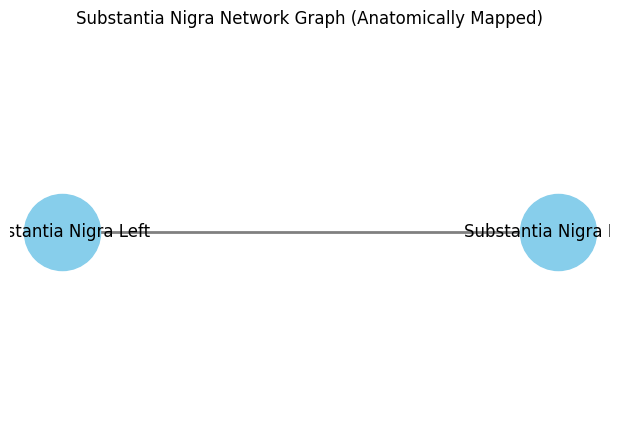

In [34]:

# Define brain regions
regions = ["Substantia Nigra Left", "Substantia Nigra Right"]

# Define a simple network (connecting left and right)
G = nx.Graph()
G.add_nodes_from(regions)
G.add_edge("Substantia Nigra Left", "Substantia Nigra Right", weight=1.0)  # Example connection

# Define anatomical positions for left and right
pos = {
    "Substantia Nigra Left": (-1, 0),  # Left side of brain
    "Substantia Nigra Right": (1, 0)   # Right side of brain
}

# Draw the graph
plt.figure(figsize=(6, 4))
nx.draw(G, pos, with_labels=True, node_size=3000, node_color="skyblue", font_size=12, edge_color="gray", width=2)
plt.title("Substantia Nigra Network Graph (Anatomically Mapped)")
plt.show()
